# Final Assignment
## CM3015 Machine Learning and Neural Networks

### Credit Card Fraud Detection with a Feedforward MLP

- Student: cy150
- Workflow: Chollet's ML workflow (problem → data → evaluation → prep → baseline → model → tuning → final eval)

---

## Step 1 — Define the problem

Chollet’s workflow keeps the project aligned with real‑world goals. It moves in clear stages from problem definition to data understanding, evaluation design, preparation, baseline, model building, tuning, and final reporting.

### Overview: Credit Card Fraud

Credit card fraud is the unauthorized use of a credit (or debit) card to make purchases, withdraw funds, or create transactions that the legitimate cardholder did not approve.

### Problem Statement


- Credit card fraud causes direct and significant financial losses: issuers, merchants, and consumers may absorb losses from unauthorized purchases and chargebacks. Fraud also creates investigative overhead (reviews, disputes) and temporary loss of funds and reputation. As a result, stricter verification and KYC are implemented by merchants and banks.

-  These organizations can also lose customers if there are excessive false declines or chargebacks. Additionally, failure to protect customers according to regulatory standards can incur penalties to banks themselves proving that credit card fraud detection is a critical technology for a functioning, safe banking and finance environment
---

## Step 2 — Identify and understand the data

### Dataset Overview
This dataset consists of credit card transactions by European cardholders. It covers two days of transactions with 492 frauds out of 284,807 transactions.
The dataset is highly imbalanced, with frauds accounting for about 0.172% of all transactions.


### Nature of the Dataset

It contains only numerical input variables resulting from a PCA transformation. Due to confidentiality, the original features and more background information are not available.

### Dataset Features
Features V1, V2, … V28 are principal components from PCA. The only features not transformed with PCA are `Time` and `Amount`.

- `Time` contains the seconds elapsed between each transaction and the first transaction in the dataset.

*Example*

| Time |      V1 |      V2 |     V3 |     V4 |      V5 |
| ---: | ------: | ------: | -----: | -----: | ------: |
|    0 | -1.3598 | -0.0728 | 2.5363 | 1.3782 | -0.3383 |
|    1 |  1.1919 |  0.2662 | 0.1665 | 0.4482 |  0.0600 |
|    1 | -1.3584 | -1.3402 | 1.7732 | 0.3798 | -0.5032 |


### Dataset Licensing

The dataset is licensed under the Database Contents License (DbCL).

According to the license (Open Data Commons), the Licensor grants a worldwide, royalty-free, non-exclusive, perpetual, irrevocable copyright license to do any act that is restricted by copyright over anything within the Contents, whether in the original medium or any other. These rights explicitly include commercial use and do not exclude any field of endeavor.

### Permission

The DbCL license explicitly allows use of this dataset for this final assignment.

### Dataset Author

- Machine Learning Group - ULB 

### Dataset Source

After browsing Kaggle, I selected a dataset that is complex and challenging while providing rich features for the model to learn from.

Link to dataset: `https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/data`

### Justification for this dataset

This dataset supports a full end-to-end deep learning workflow: clear labels, numeric features, and a real-world class imbalance that demands careful evaluation.

#### Rationale behind why this dataset was chosen

- It matches the **problem framing**: a real-world binary classification task where the positive class (fraud) is rare and costly to miss.
- It matches the **data modality**: fixed-length, fully numeric, tabular features that are well-suited to a feedforward MLP as a strong first baseline.
- It forces a realistic **evaluation setup**: extreme imbalance means accuracy is not meaningful, so the workflow naturally prioritizes PR AUC, precision/recall, and explicit threshold selection.
- It encourages good **experimental discipline**: preprocessing must be fit on the training split only (to avoid leakage) and the final test set can be kept untouched for a single, final report.

#### Limitations of this dataset and mitigation strategy

- **Limited interpretability**: V1–V28 are anonymized PCA components, so feature-level explanations are not meaningful.
  - *Mitigation*: focus on predictive performance, stability across runs, and careful threshold selection rather than per-feature interpretation.
- **Potential time effects**: `Time` reflects ordering within the 2-day window.
  - *Mitigation*: use a time-aware split (train on earlier, validate/test on later) to better reflect deployment.

---

## Step 1 Cont'd — Define success metrics

### Objective

The primary objective is to detect fraudulent transactions while minimizing false positives. Because fraud is rare, the evaluation focuses on minority-class performance and selecting an operating point that reflects the cost of errors.

## Step 3 — Choose an evaluation protocol

### Holdout Protocol

1. The data will be split into:

    - Training set
    - Validation set
    - Test set

   **Why**: we need separate data for learning parameters (train), choosing settings (validation), and an unbiased final report (test).

   **How**: use a time-aware split when possible (earlier transactions → train, later → validation/test) so evaluation better matches deployment.

2. Preprocessing decisions are fitted using the training set exclusively.

   **Why**: using any information from validation/test (even feature scaling statistics) leaks signal and inflates performance.

   **How**: fit transforms on `X_train` only (e.g., standardization mean/std, any imputation rules), then apply the fitted transforms unchanged to `X_val` and `X_test`.

3. The validation set is only used for model and threshold selection.

   **Why**: the validation set simulates unseen data during development; using it only for selection reduces the risk of overfitting the final report.

   **How**: compare candidate models using PR AUC/recall/precision on validation; choose hyperparameters and pick an operating threshold (e.g., maximize recall subject to minimum precision) using validation predictions.

4. Final performance is evaluated on the untouched test set.

   **Why**: the test set should be a single, unbiased estimate of how the chosen pipeline will perform in the real world.

   **How**: once preprocessing + model + threshold are finalized, run inference once on `X_test` and report the locked metrics (PR AUC and confusion matrix at the chosen threshold).


### Evaluation metrics

This section describes how performance will be measured based on the pre-defined success criteria.

### Primary Metrics

| Metric               | What it measures                                                       | Why it matters for fraud under heavy class imbalance                                                    |
| -------------------- | ---------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------- |
| Precision–Recall AUC | Area under the precision–recall curve across decision thresholds       | Strong overall summary metric when fraud is rare, more informative than accuracy                        |
| Recall               | True positive rate, how many actual fraud cases are correctly detected | Directly captures missed fraud risk since low recall means more fraud slips through                     |
| F1 Score             | Harmonic mean of precision and recall                                  | Useful single number when you want a balanced tradeoff between catching fraud and limiting false alarms |


### Secondary Metric

| Secondary metric                              | Description                                                                                                       | Purpose                                                                                        |
| --------------------------------------------- | ----------------------------------------------------------------------------------------------------------------- | ---------------------------------------------------------------------------------------------- |
| Confusion matrix at a predetermined threshold | Uses TP, FP, TN, FN to make tradeoffs explicit                                                                    | Shows performance at the chosen operating point and clarifies the cost of each type of mistake |
| Error rates                                   | False negative rate and false positive rate to quantify misses and false alarms                                   | Measures miss risk versus false alarm burden in a comparable way                               |
| Calibration check                             | Compare predicted probabilities with observed outcomes using a simple binning table to verify probability quality | Checks whether predicted risk scores align with real observed fraud rates                      |


#### Justification for evaluation metrics

Fraud is a rare event, so a single metric can be misleading. A model may look strong on one metric while failing in practice. The primary metric provides a consistent rule for model comparison, while secondary metrics provide the context needed to interpret false-positive and false-negative tradeoffs.

### Implications of the evaluation metrics

1. Precision reflects workload and customer friction.
2. Recall reflects loss prevention, often translating into direct financial losses.
3. PR AUC reflects ranking quality under rare fraud across thresholds.
4. The confusion matrix is reported at an operating threshold aligned with transaction behavior.


## Step 4 — Prepare the data

### Data preparation plan

To prepare the data and avoid leakage:

1. Use a time-aware split: earlier transactions for training, later transactions for validation/test.
2. Fit all preprocessing steps (scaling, imputation if needed) on the training set only.
3. Apply the same fitted transforms to validation and test sets.
4. Preserve the class imbalance during splitting to reflect real deployment.
5. Track feature distributions and label rate over time to identify drift.
6. Use a small threshold sweep on the validation set for later operating-point selection.
7. Calibrate probabilities with simple binning to sanity-check outputs.
8. Re-train periodically as base rates drift in production.

Data checks and class imbalance

- Check for missing values, big outliers, and changes between the train/val/test splits.
- Scale features using numbers from the training set only.
- Handle imbalance with class weights or resampling.
- Keep notes of every preprocessing step so results are repeatable.

---

In [1]:
import sys

# Install into THIS kernel environment
%pip -q install -U "kagglehub[pandas-datasets]"

import kagglehub
import pandas as pd

print("Kernel Python:", sys.version)
print("Kernel executable:", sys.executable)

# Download the raw file first, then read with pandas (avoids kagglehub's UTF-8 encoding issue)
dataset_path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")
print("Dataset downloaded to:", dataset_path)

import os
csv_path = os.path.join(dataset_path, "creditcard.csv")
df = pd.read_csv(csv_path)

print(f"Shape: {df.shape}")
print(df.head())


Note: you may need to restart the kernel to use updated packages.


Kernel Python: 3.12.3 (main, Nov  6 2025, 13:44:16) [GCC 13.3.0]
Kernel executable: /usr/bin/python3
Dataset downloaded to: /home/ubuntu/.cache/kagglehub/datasets/mlg-ulb/creditcardfraud/versions/3


Shape: (284807, 31)
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26 

### Step 4 implementation (code)

The code below loads the dataset from `data/creditcard.csv`.
If the file is missing, it will try to download it using `kagglehub` and then save it to `data/creditcard.csv`.

- Expected columns include `Time`, `Amount`, `V1`…`V28`, and `Class` (target label).


In [2]:
from pathlib import Path
import os

import numpy as np
import pandas as pd

DATA_PATH = Path("data/creditcard.csv")

# If the CSV isn't present locally, try fetching it via kagglehub.
if not DATA_PATH.exists():
    try:
        import kagglehub

        # Download the raw files (avoids kagglehub's internal UTF-8 read issue)
        dataset_dir = kagglehub.dataset_download("mlg-ulb/creditcardfraud")
        src_csv = os.path.join(dataset_dir, "creditcard.csv")
        df = pd.read_csv(src_csv)

        # Cache locally so future runs don't re-download
        DATA_PATH.parent.mkdir(parents=True, exist_ok=True)
        df.to_csv(DATA_PATH, index=False)
        print("Downloaded via kagglehub and saved to:", DATA_PATH)
    except Exception as e:
        raise FileNotFoundError(
            f"Could not find {DATA_PATH} and kagglehub download failed.\n"
            "Either place the file at data/creditcard.csv, or configure Kaggle access for kagglehub, then rerun.\n"
            f"Original error: {type(e).__name__}: {e}"
        ) from e
else:
    df = pd.read_csv(DATA_PATH)
    print("Loaded:", DATA_PATH)

print("Shape:", df.shape)
print(df.head(3))

if "Class" not in df.columns:
    raise ValueError("Expected a 'Class' column (0=legit, 1=fraud).")

fraud_rate = df["Class"].mean()
print(f"Fraud rate: {fraud_rate:.6f} ({df['Class'].sum()} / {len(df)})")


Loaded: data/creditcard.csv
Shape: (284807, 31)
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   

        V26       V27       V28  Amount  Class  
0 -0.189115  0.133558 -0.021053  149.62      0  
1  0.125895 -0.008983  0.014724    2.69      0  
2 -0.139097 -0.055353 -0.059752  378.66      0  

[3 rows x 31 columns]
Fraud rate: 0.001727 (492 / 284807)


### Exploratory Data Analysis (EDA) — Visualizing the Dataset

Before splitting and modelling, we explore the dataset visually. These charts serve several purposes:

1. **Class distribution** — Quantify and visualize the extreme imbalance between fraud and non-fraud.
2. **Transaction amount** — Compare the spending patterns of fraudulent vs legitimate transactions.
3. **Transaction time** — Examine when transactions (and fraud) occur over the 2-day window.
4. **Feature correlations** — Identify which features are most associated with the target and with each other.
5. **Feature distributions by class** — Highlight which PCA components separate fraud from non-fraud most clearly.
6. **Dimensionality reduction** — Use t-SNE to project all 30 features into 2D and visualize class separation.

All visualizations use the full dataset before any splitting, so no leakage concerns arise at this stage.

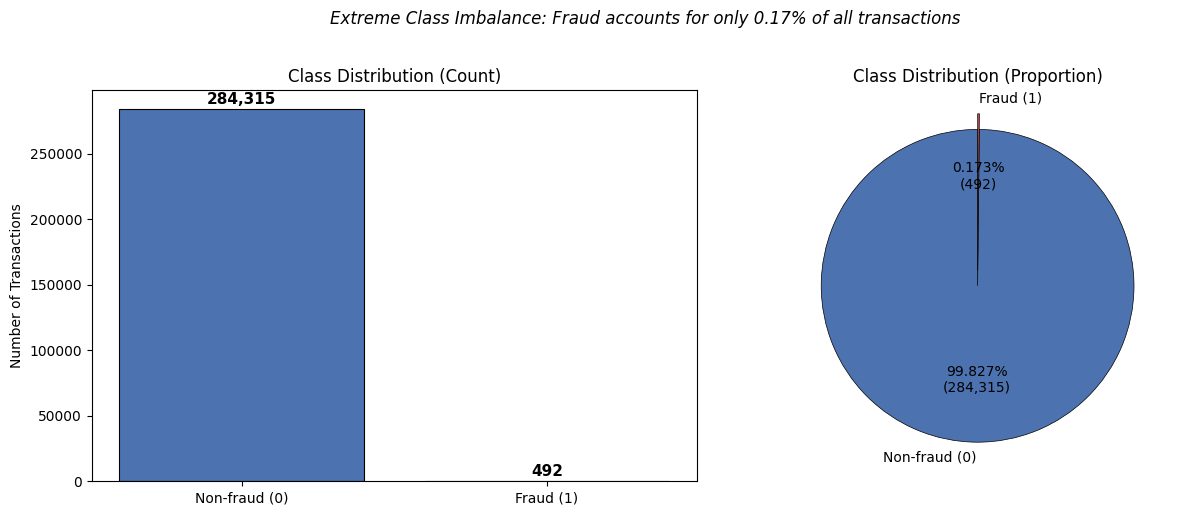

Non-fraud:  284,315  (99.8273%)
Fraud:          492  (0.1727%)
Imbalance ratio: 1 fraud per 577 legitimate transactions


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------------------------------------------------------
# 1. Class Distribution — Bar chart + Pie chart
# ---------------------------------------------------------------------------
class_counts = df["Class"].value_counts().sort_index()
labels = ["Non-fraud (0)", "Fraud (1)"]
colors = ["#4c72b0", "#c44e52"]

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# Bar chart with log-scale option for visibility
bars = axes[0].bar(labels, class_counts.values, color=colors, edgecolor="black", linewidth=0.8)
axes[0].set_ylabel("Number of Transactions")
axes[0].set_title("Class Distribution (Count)")
for bar, count in zip(bars, class_counts.values):
    axes[0].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1500,
                 f"{count:,}", ha="center", va="bottom", fontsize=11, fontweight="bold")

# Pie chart with percentage
axes[1].pie(
    class_counts.values,
    labels=labels,
    autopct=lambda pct: f"{pct:.3f}%\n({int(round(pct / 100 * class_counts.sum())):,})",
    colors=colors,
    startangle=90,
    explode=(0, 0.1),
    textprops={"fontsize": 10},
    wedgeprops={"edgecolor": "black", "linewidth": 0.5},
)
axes[1].set_title("Class Distribution (Proportion)")

plt.suptitle("Extreme Class Imbalance: Fraud accounts for only 0.17% of all transactions",
             fontsize=12, y=1.02, fontstyle="italic")
plt.tight_layout()
plt.show()

print(f"Non-fraud: {class_counts[0]:>8,}  ({class_counts[0]/len(df)*100:.4f}%)")
print(f"Fraud:     {class_counts[1]:>8,}  ({class_counts[1]/len(df)*100:.4f}%)")
print(f"Imbalance ratio: 1 fraud per {class_counts[0]//class_counts[1]:,} legitimate transactions")

/tmp/ipykernel_13778/2906343844.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[2].boxplot(box_data, labels=["Non-fraud", "Fraud"], patch_artist=True,


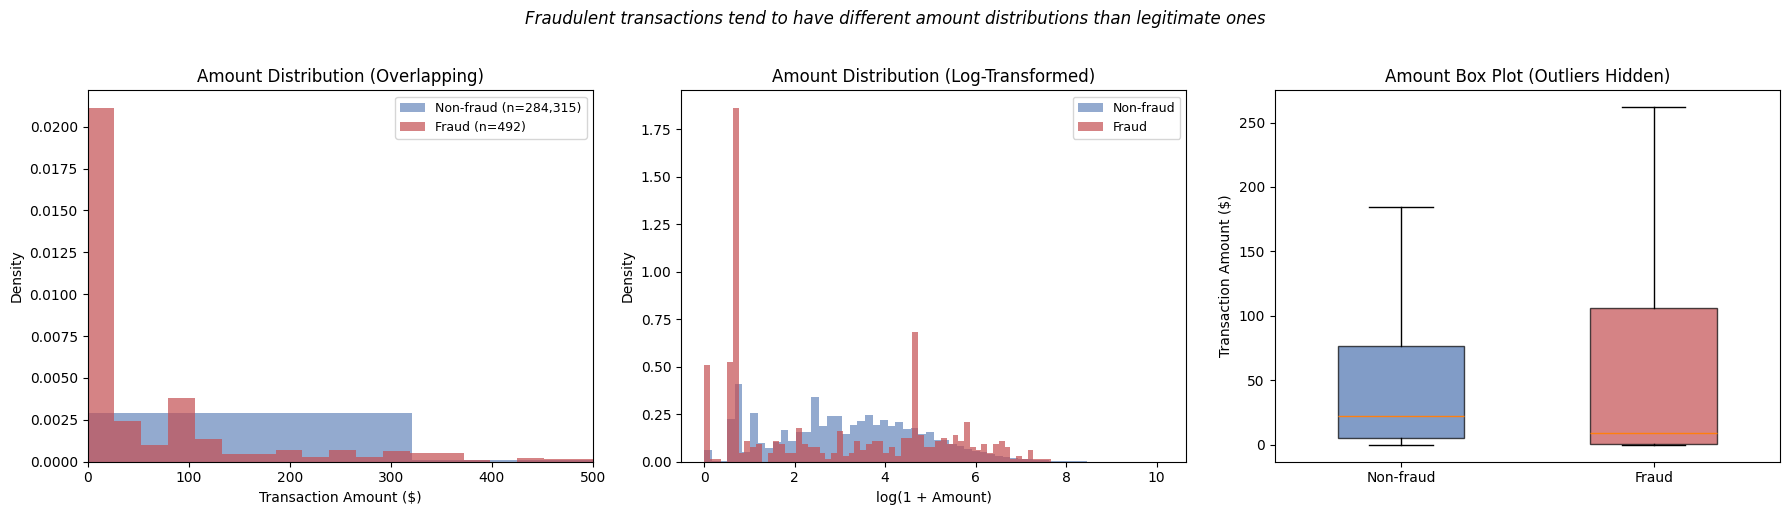

Amount summary statistics:
  Non-fraud — mean: $88.29, median: $22.00, std: $250.11, max: $25691.16
  Fraud     — mean: $122.21, median: $9.25, std: $256.68, max: $2125.87


In [4]:
# ---------------------------------------------------------------------------
# 2. Transaction Amount Distribution — Fraud vs Non-fraud
# ---------------------------------------------------------------------------
fraud_amounts = df.loc[df["Class"] == 1, "Amount"]
legit_amounts = df.loc[df["Class"] == 0, "Amount"]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# (a) Overlapping histograms (log scale on y-axis for visibility)
axes[0].hist(legit_amounts, bins=80, alpha=0.6, color="#4c72b0",
             label=f"Non-fraud (n={len(legit_amounts):,})", density=True)
axes[0].hist(fraud_amounts, bins=80, alpha=0.7, color="#c44e52",
             label=f"Fraud (n={len(fraud_amounts):,})", density=True)
axes[0].set_xlabel("Transaction Amount ($)")
axes[0].set_ylabel("Density")
axes[0].set_title("Amount Distribution (Overlapping)")
axes[0].legend(fontsize=9)
axes[0].set_xlim(0, 500)

# (b) Log-transformed amount histogram
axes[1].hist(np.log1p(legit_amounts), bins=60, alpha=0.6, color="#4c72b0",
             label="Non-fraud", density=True)
axes[1].hist(np.log1p(fraud_amounts), bins=60, alpha=0.7, color="#c44e52",
             label="Fraud", density=True)
axes[1].set_xlabel("log(1 + Amount)")
axes[1].set_ylabel("Density")
axes[1].set_title("Amount Distribution (Log-Transformed)")
axes[1].legend(fontsize=9)

# (c) Box plot comparison
box_data = [legit_amounts.values, fraud_amounts.values]
bp = axes[2].boxplot(box_data, labels=["Non-fraud", "Fraud"], patch_artist=True,
                     showfliers=False, widths=0.5)
bp["boxes"][0].set_facecolor("#4c72b0")
bp["boxes"][1].set_facecolor("#c44e52")
for box in bp["boxes"]:
    box.set_alpha(0.7)
axes[2].set_ylabel("Transaction Amount ($)")
axes[2].set_title("Amount Box Plot (Outliers Hidden)")

plt.suptitle("Fraudulent transactions tend to have different amount distributions than legitimate ones",
             fontsize=12, y=1.02, fontstyle="italic")
plt.tight_layout()
plt.show()

# Summary statistics
print("Amount summary statistics:")
print(f"  Non-fraud — mean: ${legit_amounts.mean():.2f}, median: ${legit_amounts.median():.2f}, "
      f"std: ${legit_amounts.std():.2f}, max: ${legit_amounts.max():.2f}")
print(f"  Fraud     — mean: ${fraud_amounts.mean():.2f}, median: ${fraud_amounts.median():.2f}, "
      f"std: ${fraud_amounts.std():.2f}, max: ${fraud_amounts.max():.2f}")

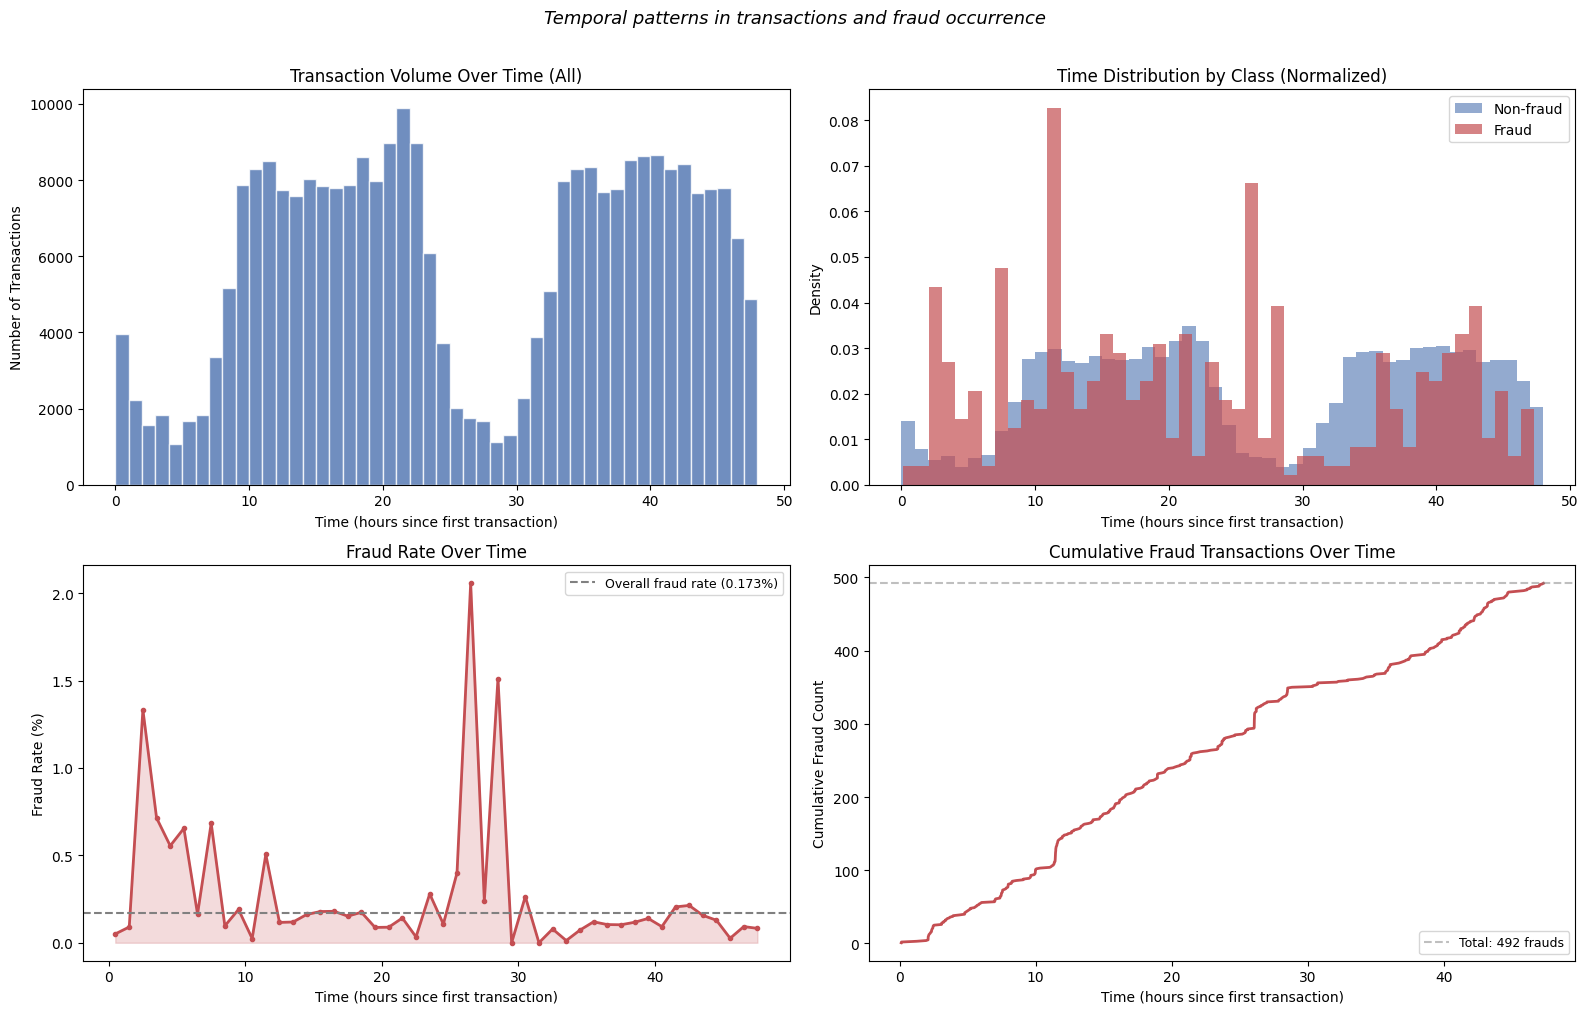

In [5]:
# ---------------------------------------------------------------------------
# 3. Transaction Time Distribution — Fraud vs Non-fraud + Fraud rate over time
# ---------------------------------------------------------------------------
time_hours = df["Time"] / 3600  # convert seconds to hours

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# (a) Overall transaction volume over time
axes[0, 0].hist(time_hours, bins=48, color="#4c72b0", edgecolor="white", alpha=0.8)
axes[0, 0].set_xlabel("Time (hours since first transaction)")
axes[0, 0].set_ylabel("Number of Transactions")
axes[0, 0].set_title("Transaction Volume Over Time (All)")

# (b) Fraud vs Non-fraud time distribution
axes[0, 1].hist(time_hours[df["Class"] == 0], bins=48, alpha=0.6, color="#4c72b0",
                label="Non-fraud", density=True)
axes[0, 1].hist(time_hours[df["Class"] == 1], bins=48, alpha=0.7, color="#c44e52",
                label="Fraud", density=True)
axes[0, 1].set_xlabel("Time (hours since first transaction)")
axes[0, 1].set_ylabel("Density")
axes[0, 1].set_title("Time Distribution by Class (Normalized)")
axes[0, 1].legend()

# (c) Fraud rate over time (binned)
n_bins_time = 48
time_bins = pd.cut(time_hours, bins=n_bins_time)
fraud_rate_by_time = df.groupby(time_bins, observed=False)["Class"].mean()
bin_centers = [interval.mid for interval in fraud_rate_by_time.index]

axes[1, 0].plot(bin_centers, fraud_rate_by_time.values * 100, color="#c44e52",
                linewidth=2, marker="o", markersize=3)
axes[1, 0].fill_between(bin_centers, fraud_rate_by_time.values * 100,
                         alpha=0.2, color="#c44e52")
axes[1, 0].set_xlabel("Time (hours since first transaction)")
axes[1, 0].set_ylabel("Fraud Rate (%)")
axes[1, 0].set_title("Fraud Rate Over Time")
axes[1, 0].axhline(y=df["Class"].mean() * 100, color="grey", linestyle="--",
                    label=f"Overall fraud rate ({df['Class'].mean()*100:.3f}%)")
axes[1, 0].legend(fontsize=9)

# (d) Cumulative fraud count over time
fraud_times = time_hours[df["Class"] == 1].sort_values()
axes[1, 1].plot(fraud_times.values, np.arange(1, len(fraud_times) + 1),
                color="#c44e52", linewidth=2)
axes[1, 1].set_xlabel("Time (hours since first transaction)")
axes[1, 1].set_ylabel("Cumulative Fraud Count")
axes[1, 1].set_title("Cumulative Fraud Transactions Over Time")
axes[1, 1].axhline(y=len(fraud_times), color="grey", linestyle="--", alpha=0.5,
                    label=f"Total: {len(fraud_times)} frauds")
axes[1, 1].legend(fontsize=9)

plt.suptitle("Temporal patterns in transactions and fraud occurrence",
             fontsize=13, y=1.01, fontstyle="italic")
plt.tight_layout()
plt.show()

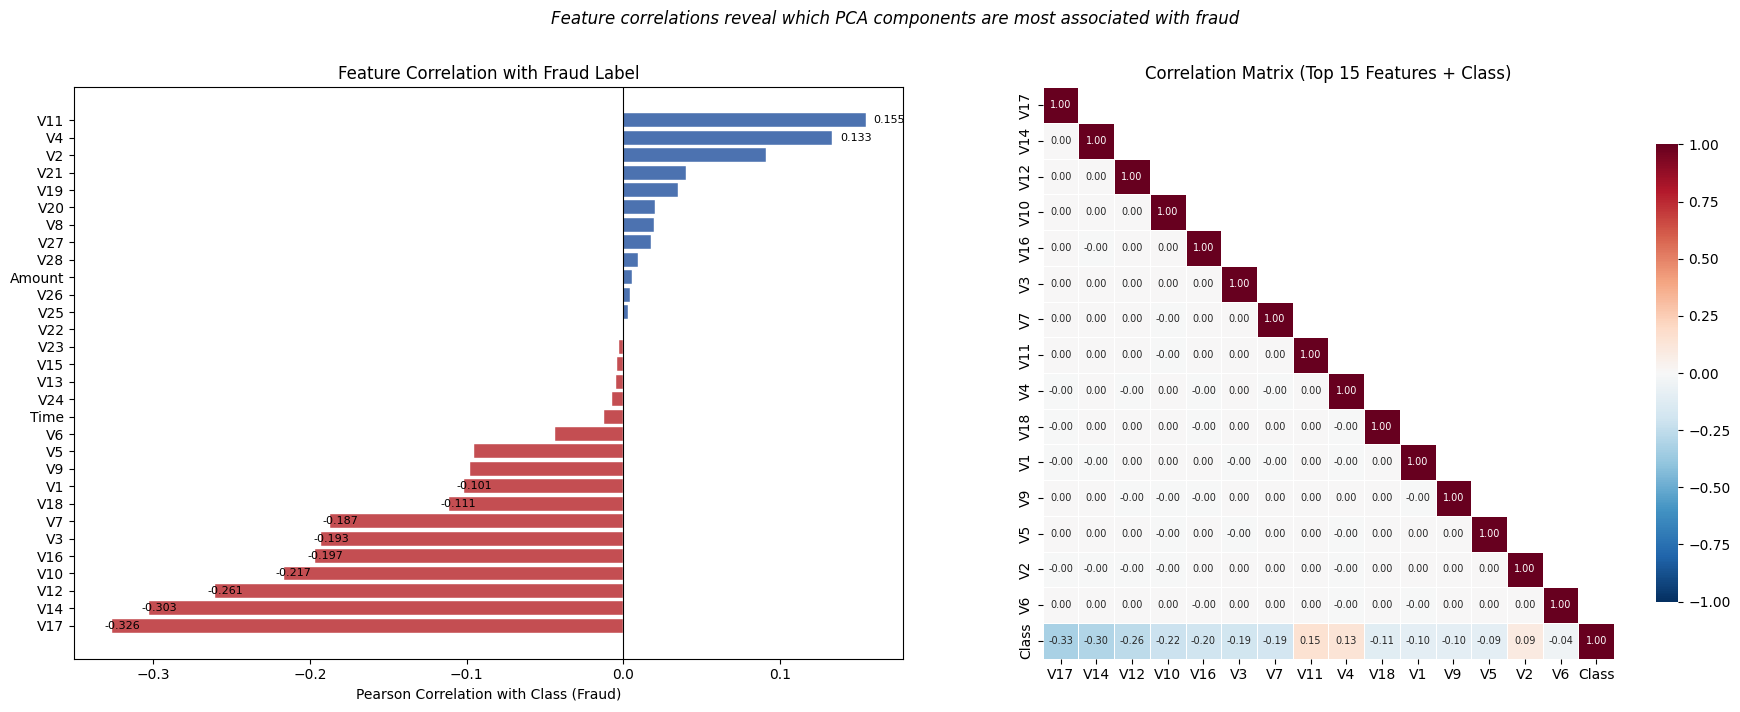

Top 5 positively correlated with fraud:
       V11: +0.1549
        V4: +0.1334
        V2: +0.0913
       V21: +0.0404
       V19: +0.0348

Top 5 negatively correlated with fraud:
       V17: -0.3265
       V14: -0.3025
       V12: -0.2606
       V10: -0.2169
       V16: -0.1965


In [6]:
# ---------------------------------------------------------------------------
# 4. Correlation Heatmap — Feature correlations with the target
# ---------------------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# (a) Correlation of each feature with Class (target)
corr_with_target = df.drop(columns=["Class"]).corrwith(df["Class"]).sort_values()

bar_colors = ["#c44e52" if v < 0 else "#4c72b0" for v in corr_with_target.values]
axes[0].barh(corr_with_target.index, corr_with_target.values, color=bar_colors,
             edgecolor="white", linewidth=0.3)
axes[0].set_xlabel("Pearson Correlation with Class (Fraud)")
axes[0].set_title("Feature Correlation with Fraud Label")
axes[0].axvline(x=0, color="black", linewidth=0.8)

# Highlight the most correlated features
for i, (feat, val) in enumerate(corr_with_target.items()):
    if abs(val) > 0.1:
        axes[0].text(val + 0.005 * np.sign(val), i, f"{val:.3f}", va="center", fontsize=8)

# (b) Correlation matrix heatmap of top features (most correlated with Class)
top_features = corr_with_target.abs().nlargest(15).index.tolist()
top_features_with_class = top_features + ["Class"]
corr_matrix = df[top_features_with_class].corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="RdBu_r",
    center=0,
    vmin=-1,
    vmax=1,
    square=True,
    linewidths=0.5,
    ax=axes[1],
    cbar_kws={"shrink": 0.8},
    annot_kws={"fontsize": 7},
)
axes[1].set_title("Correlation Matrix (Top 15 Features + Class)")

plt.suptitle("Feature correlations reveal which PCA components are most associated with fraud",
             fontsize=12, y=1.01, fontstyle="italic")
plt.tight_layout()
plt.show()

# Print top positive and negative correlations
print("Top 5 positively correlated with fraud:")
for feat, val in corr_with_target.nlargest(5).items():
    print(f"  {feat:>8s}: {val:+.4f}")
print("\nTop 5 negatively correlated with fraud:")
for feat, val in corr_with_target.nsmallest(5).items():
    print(f"  {feat:>8s}: {val:+.4f}")

/tmp/ipykernel_13778/1859238190.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=plot_df, x="Class", y=feat, palette={"Non-fraud": "#4c72b0", "Fraud": "#c44e52"},
/tmp/ipykernel_13778/1859238190.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=plot_df, x="Class", y=feat, palette={"Non-fraud": "#4c72b0", "Fraud": "#c44e52"},
/tmp/ipykernel_13778/1859238190.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=plot_df, x="Class", y=feat, palette={"Non-fraud": "#4c72b0", "Fraud": "#c44e52"},
/tmp/ipykernel_13778/1

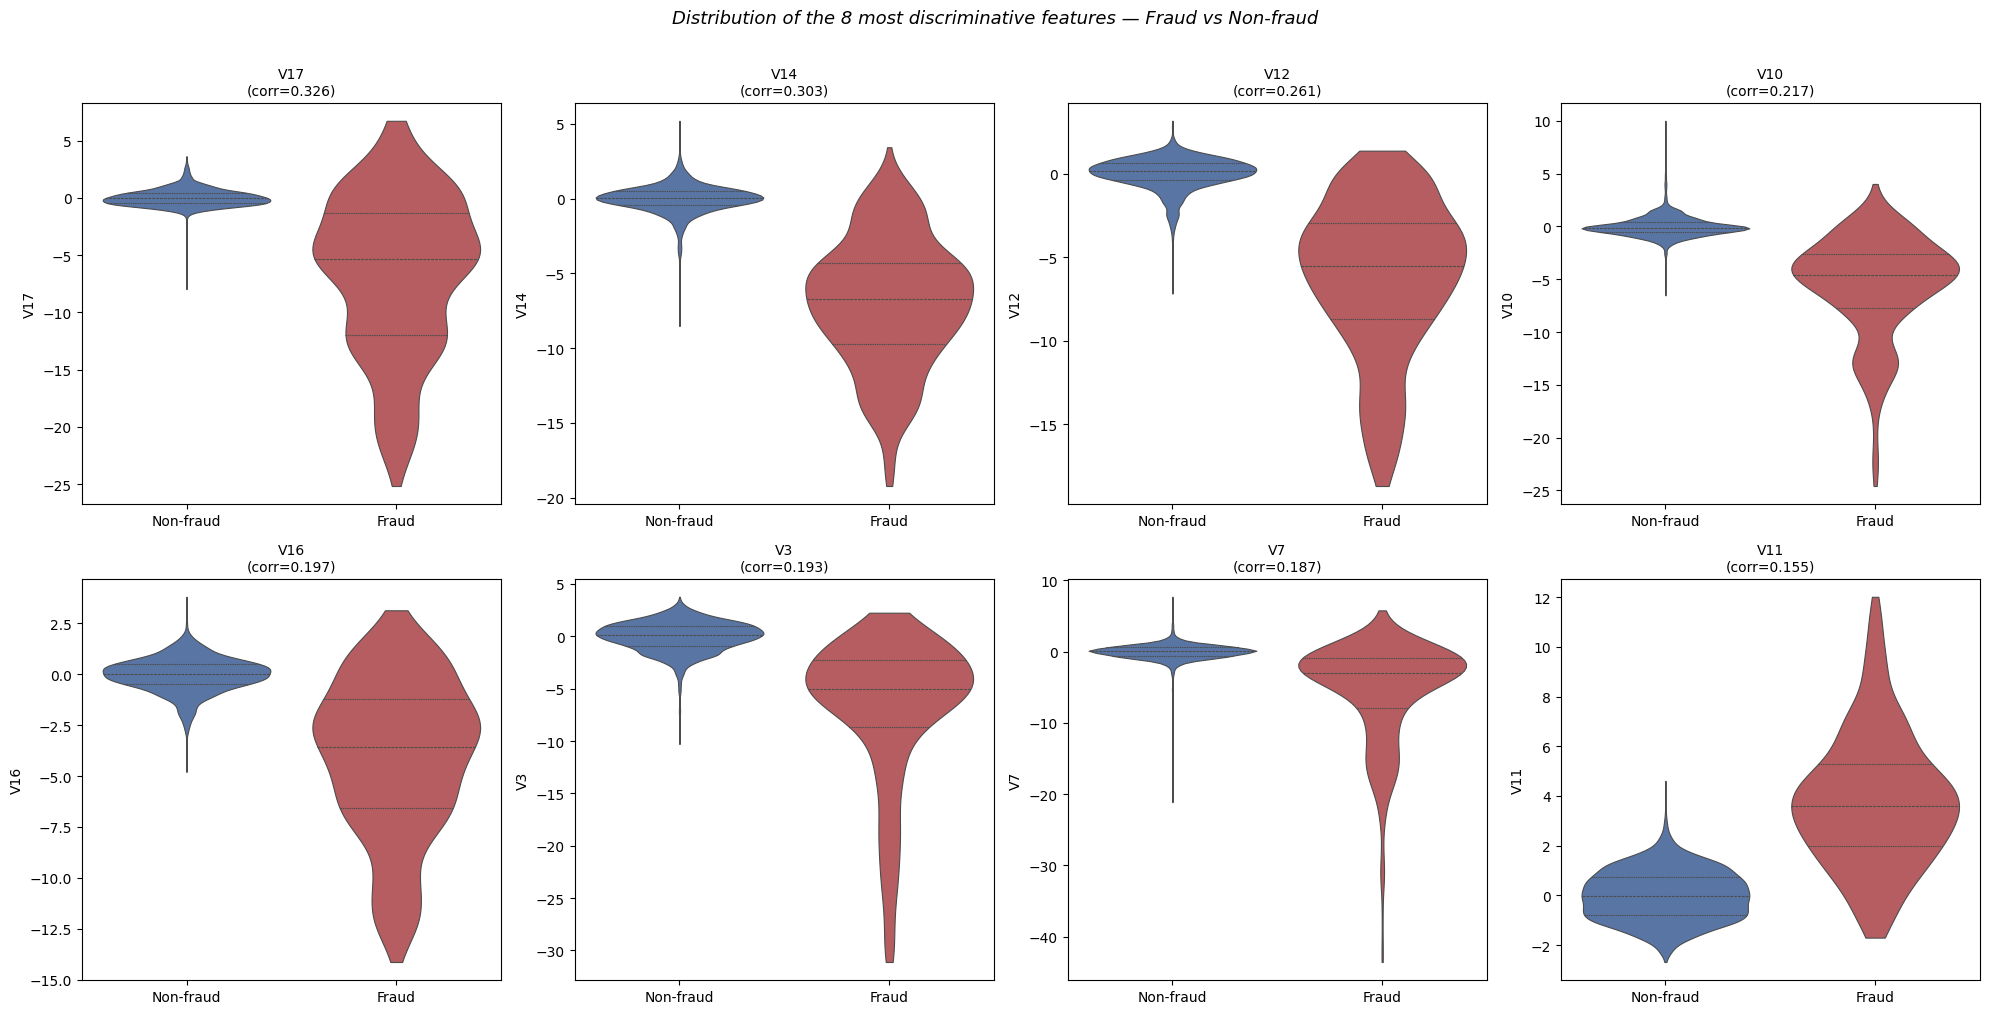

In [7]:
# ---------------------------------------------------------------------------
# 5. Violin + Strip Plots — Top discriminative features by class
# ---------------------------------------------------------------------------
# Select the 8 features most correlated (positive or negative) with Class
corr_abs = df.drop(columns=["Class"]).corrwith(df["Class"]).abs().sort_values(ascending=False)
top8_features = corr_abs.head(8).index.tolist()

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

for i, feat in enumerate(top8_features):
    # Subsample non-fraud for clearer violin plots (fraud is already small)
    fraud_vals = df.loc[df["Class"] == 1, feat]
    legit_sample = df.loc[df["Class"] == 0, feat].sample(n=min(2000, (df["Class"] == 0).sum()),
                                                          random_state=42)
    plot_df = pd.DataFrame({
        feat: pd.concat([legit_sample, fraud_vals], ignore_index=True),
        "Class": ["Non-fraud"] * len(legit_sample) + ["Fraud"] * len(fraud_vals),
    })

    sns.violinplot(data=plot_df, x="Class", y=feat, palette={"Non-fraud": "#4c72b0", "Fraud": "#c44e52"},
                   inner="quartile", ax=axes[i], cut=0, linewidth=0.8)
    axes[i].set_title(f"{feat}\n(corr={corr_abs[feat]:.3f})", fontsize=10)
    axes[i].set_xlabel("")

plt.suptitle("Distribution of the 8 most discriminative features — Fraud vs Non-fraud",
             fontsize=13, y=1.01, fontstyle="italic")
plt.tight_layout()
plt.show()

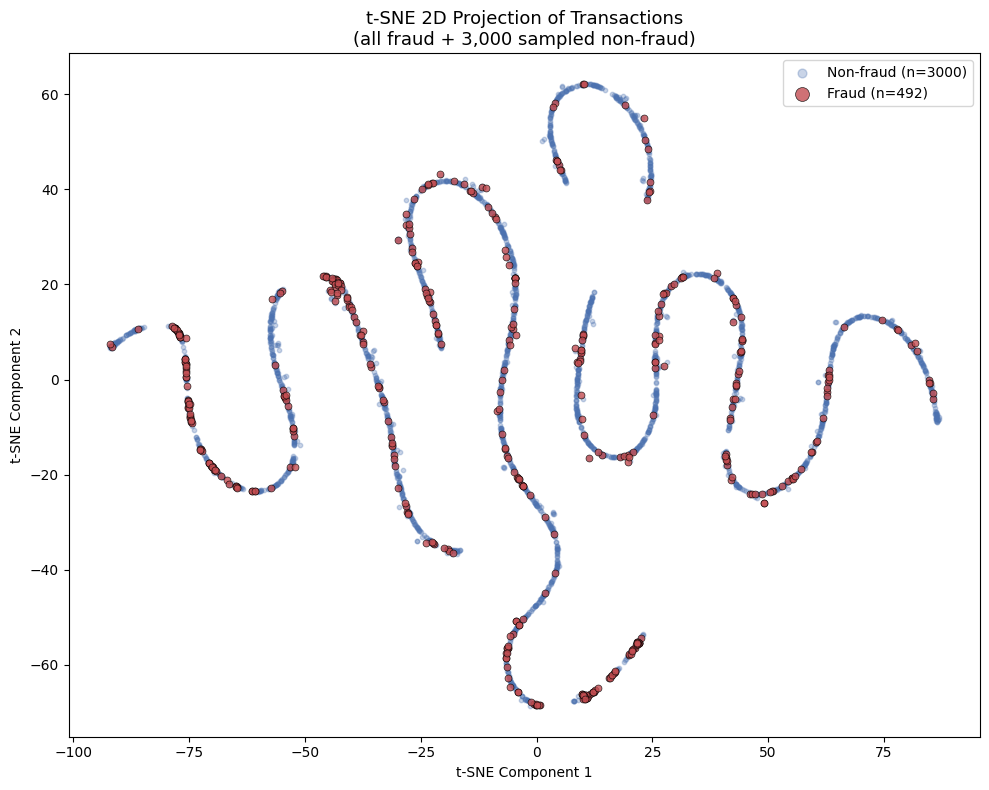

t-SNE computed on 3,492 samples (492 fraud + 3000 non-fraud)


In [8]:
# ---------------------------------------------------------------------------
# 6. t-SNE 2D Projection — Visualize class separation in reduced dimensions
# ---------------------------------------------------------------------------
from sklearn.manifold import TSNE

# Subsample for speed: all fraud + a random sample of non-fraud
np.random.seed(42)
fraud_idx = df[df["Class"] == 1].index.values
legit_idx = np.random.choice(df[df["Class"] == 0].index.values, size=3000, replace=False)
sample_idx = np.concatenate([legit_idx, fraud_idx])
np.random.shuffle(sample_idx)

X_sample = df.loc[sample_idx, [c for c in df.columns if c != "Class"]].values
y_sample = df.loc[sample_idx, "Class"].values

# Run t-SNE
# scikit-learn 1.8+ replaces n_iter with max_iter
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000, learning_rate="auto")
X_tsne = tsne.fit_transform(X_sample)

# Plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot non-fraud first (background), then fraud on top
mask_legit = y_sample == 0
mask_fraud = y_sample == 1

ax.scatter(X_tsne[mask_legit, 0], X_tsne[mask_legit, 1],
           c="#4c72b0", alpha=0.3, s=10, label=f"Non-fraud (n={mask_legit.sum()})")
ax.scatter(X_tsne[mask_fraud, 0], X_tsne[mask_fraud, 1],
           c="#c44e52", alpha=0.8, s=25, edgecolors="black", linewidth=0.5,
           label=f"Fraud (n={mask_fraud.sum()})", zorder=5)

ax.set_xlabel("t-SNE Component 1")
ax.set_ylabel("t-SNE Component 2")
ax.set_title("t-SNE 2D Projection of Transactions\n(all fraud + 3,000 sampled non-fraud)",
             fontsize=13)
ax.legend(loc="upper right", fontsize=10, markerscale=2)
plt.tight_layout()
plt.show()

print(f"t-SNE computed on {len(sample_idx):,} samples "
      f"({mask_fraud.sum()} fraud + {mask_legit.sum()} non-fraud)")

### EDA Summary

The visualizations above reveal several key characteristics of the dataset:

1. **Extreme class imbalance**: Fraud accounts for only ~0.17% of transactions. This confirms that accuracy is meaningless as a metric — a model predicting all non-fraud would achieve 99.83% accuracy while catching zero fraud.

2. **Amount differences**: Fraudulent transactions tend to have different amount distributions compared to legitimate ones. The log-transformed view and box plots make these differences more visible.

3. **Temporal patterns**: Transaction volume is not uniform over the 2-day window, and the fraud rate fluctuates over time. This supports the decision to use a time-aware train/validation/test split.

4. **Feature correlations**: Several PCA components (e.g., V14, V17, V12, V10) show moderate-to-strong correlations with the fraud label. The correlation heatmap also confirms that PCA components are largely uncorrelated with each other (as expected from PCA), which is beneficial for modelling.

5. **Violin plots**: The most discriminative features show visibly different distributions for fraud vs non-fraud, with fraud transactions having shifted or broader distributions in key components.

6. **t-SNE projection**: The 2D projection shows that fraud transactions are partially separable from legitimate ones in the feature space, though there is overlap. This suggests a non-linear model like an MLP may capture boundaries that a linear model cannot.

---

In [9]:
try:
    from sklearn.preprocessing import StandardScaler
except ImportError as e:
    raise ImportError(
        "scikit-learn is required for StandardScaler. Install it (e.g., `pip install scikit-learn`) and rerun."
    ) from e

# Time-aware ordering (closer to deployment): train on earlier, test on later
if "Time" in df.columns:
    df = df.sort_values("Time").reset_index(drop=True)

feature_names = [c for c in df.columns if c != "Class"]
X = df[feature_names].to_numpy(dtype=np.float32)
y = df["Class"].to_numpy(dtype=np.int64)

n = len(df)
train_end = int(0.70 * n)
val_end = int(0.85 * n)

X_train, y_train = X[:train_end], y[:train_end]
X_val, y_val = X[train_end:val_end], y[train_end:val_end]
X_test, y_test = X[val_end:], y[val_end:]

print("Split sizes:")
print("- train:", X_train.shape, "fraud_rate=", float(y_train.mean()))
print("- val:  ", X_val.shape, "fraud_rate=", float(y_val.mean()))
print("- test: ", X_test.shape, "fraud_rate=", float(y_test.mean()))

# Fit preprocessing on TRAIN ONLY to avoid leakage
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train).astype(np.float32)
X_val_scaled = scaler.transform(X_val).astype(np.float32)
X_test_scaled = scaler.transform(X_test).astype(np.float32)

# Optional: class weights for imbalanced training
neg = int((y_train == 0).sum())
pos = int((y_train == 1).sum())
class_weight = {0: 1.0, 1: (neg / max(pos, 1))}
print("class_weight:", class_weight)


Split sizes:
- train: (199364, 30) fraud_rate= 0.0019261250777472363
- val:   (42721, 30) fraud_rate= 0.001310830738980829
- test:  (42722, 30) fraud_rate= 0.0012171714807359207
class_weight: {0: 1.0, 1: 518.1770833333334}


### Split Success

The split ran successfully because we created **three non-overlapping subsets** (train/val/test) with clear row counts and the same number of input features (30 columns). The sizes are sensible (about 70% / 15% / 15%), and the **fraud rate stays low and in the expected range** across all splits.

The computed `class_weight` is large for class 1, which confirms fraud is rare in the training set and will be up-weighted during training. Finally, scaling is fit on `X_train` only and then applied to validation/test, which helps prevent data leakage.

## Step 5 — Establish a baseline and pick a starting model

In Chollet's workflow, Step 5 answers two questions: *"What is the simplest thing that could work?"* and *"What is a reasonable starting architecture?"* Before investing effort in tuning, we need reference points that tell us whether a more complex model is actually adding value.

### Why baselines matter

A baseline anchors the evaluation. Without one, there is no way to know whether a model's PR AUC of 0.70 is good or bad for this particular dataset and split. We establish **two** baselines of increasing complexity:

| Baseline | What it tells us |
| --- | --- |
| Trivial baseline (always predict non-fraud) | Absolute floor — any model that cannot beat it is worse than useless. |
| Logistic regression (class-weighted linear classifier) | Simplest learned model; shows how much performance comes from linear relationships alone and how much headroom remains for a non-linear MLP. |

### Starting model choice

After the baselines, we pick a starting deep-learning architecture. The choice is a **small-to-medium feedforward multilayer perceptron (MLP)** because:

- The input is fixed-length, fully numeric, and tabular — ideal for Dense layers.
- An MLP can capture non-linear interactions between PCA components that logistic regression cannot.
- It is fast to train and simple to debug before moving to more complex architectures.

The rest of this section implements these three models, evaluates them on the **validation set only**, and compares their performance side by side.

### 5.0 — Pre-modelling data sanity check

Before building any model, we verify the data is clean and confirm the assumptions from Step 4 still hold after splitting and scaling. This catches issues (NaNs introduced by scaling, duplicated rows leaking across splits, unexpected feature ranges) that would silently corrupt every model downstream.

In [10]:
# ---------------------------------------------------------------------------
# Data sanity check before modelling
# ---------------------------------------------------------------------------
print("=== Missing values ===")
print(f"  X_train NaN count: {np.isnan(X_train_scaled).sum()}")
print(f"  X_val   NaN count: {np.isnan(X_val_scaled).sum()}")
print(f"  X_test  NaN count: {np.isnan(X_test_scaled).sum()}")

print("\n=== Infinite values ===")
print(f"  X_train Inf count: {np.isinf(X_train_scaled).sum()}")
print(f"  X_val   Inf count: {np.isinf(X_val_scaled).sum()}")
print(f"  X_test  Inf count: {np.isinf(X_test_scaled).sum()}")

print("\n=== Duplicate rows in original df ===")
n_dup = df.duplicated().sum()
print(f"  Total duplicates: {n_dup} ({n_dup / len(df) * 100:.2f}%)")

print("\n=== Feature range after scaling (train) ===")
train_df_scaled = pd.DataFrame(X_train_scaled, columns=feature_names)
print(train_df_scaled.describe().loc[["mean", "std", "min", "max"]].round(2).to_string())

print("\n=== Label counts per split ===")
for name, labels in [("train", y_train), ("val", y_val), ("test", y_test)]:
    unique, counts = np.unique(labels, return_counts=True)
    print(f"  {name:5s}: " + ", ".join(f"class {u}={c}" for u, c in zip(unique, counts)))

=== Missing values ===
  X_train NaN count: 0
  X_val   NaN count: 0
  X_test  NaN count: 0

=== Infinite values ===
  X_train Inf count: 0
  X_val   Inf count: 0
  X_test  Inf count: 0

=== Duplicate rows in original df ===


  Total duplicates: 1081 (0.38%)

=== Feature range after scaling (train) ===
      Time     V1     V2     V3     V4     V5     V6     V7     V8     V9    V10    V11    V12   V13    V14   V15    V16    V17    V18   V19    V20    V21    V22    V23   V24    V25   V26    V27     V28  Amount
mean  0.00   0.00   0.00   0.00   0.00   0.00  -0.00   0.00  -0.00   0.00  -0.00   0.00   0.00 -0.00  -0.00  0.00   0.00   0.00   0.00 -0.00  -0.00   0.00   0.00   0.00  0.00   0.00 -0.00  -0.00    0.00   -0.00
std   1.00   1.00   1.00   1.00   1.00   1.00   1.00   1.00   1.00   1.00   1.00   1.00   1.00  1.00   1.00  1.00   1.00   1.00   1.00  1.00   1.00   1.00   1.00   1.00  1.00   1.00  1.00   1.00    1.00    1.00
min  -2.04 -29.77 -44.84 -23.49  -4.12 -30.87 -19.99 -35.72 -60.54 -11.84 -22.49  -4.73 -17.01 -5.65 -19.82 -4.85 -15.94 -28.28 -11.27 -8.79 -33.69 -47.16 -15.75 -73.34 -4.71 -21.08 -5.35 -57.27  -37.32   -0.36
max   1.81   1.35  13.60   6.26  12.01  25.64  17.15  30.15  16.52  13.72  21.

### 5.0.1 — Post-split visual sanity checks

The numerical sanity check above confirmed there are no NaNs, Infs, or severe anomalies. The following charts provide a **visual** verification that:

1. The splits have sensible class distributions (no accidental stratification issues).
2. Feature distributions are similar across train/val/test (no unexpected drift from the time-aware split).
3. The Amount and Time distributions remain consistent across splits.

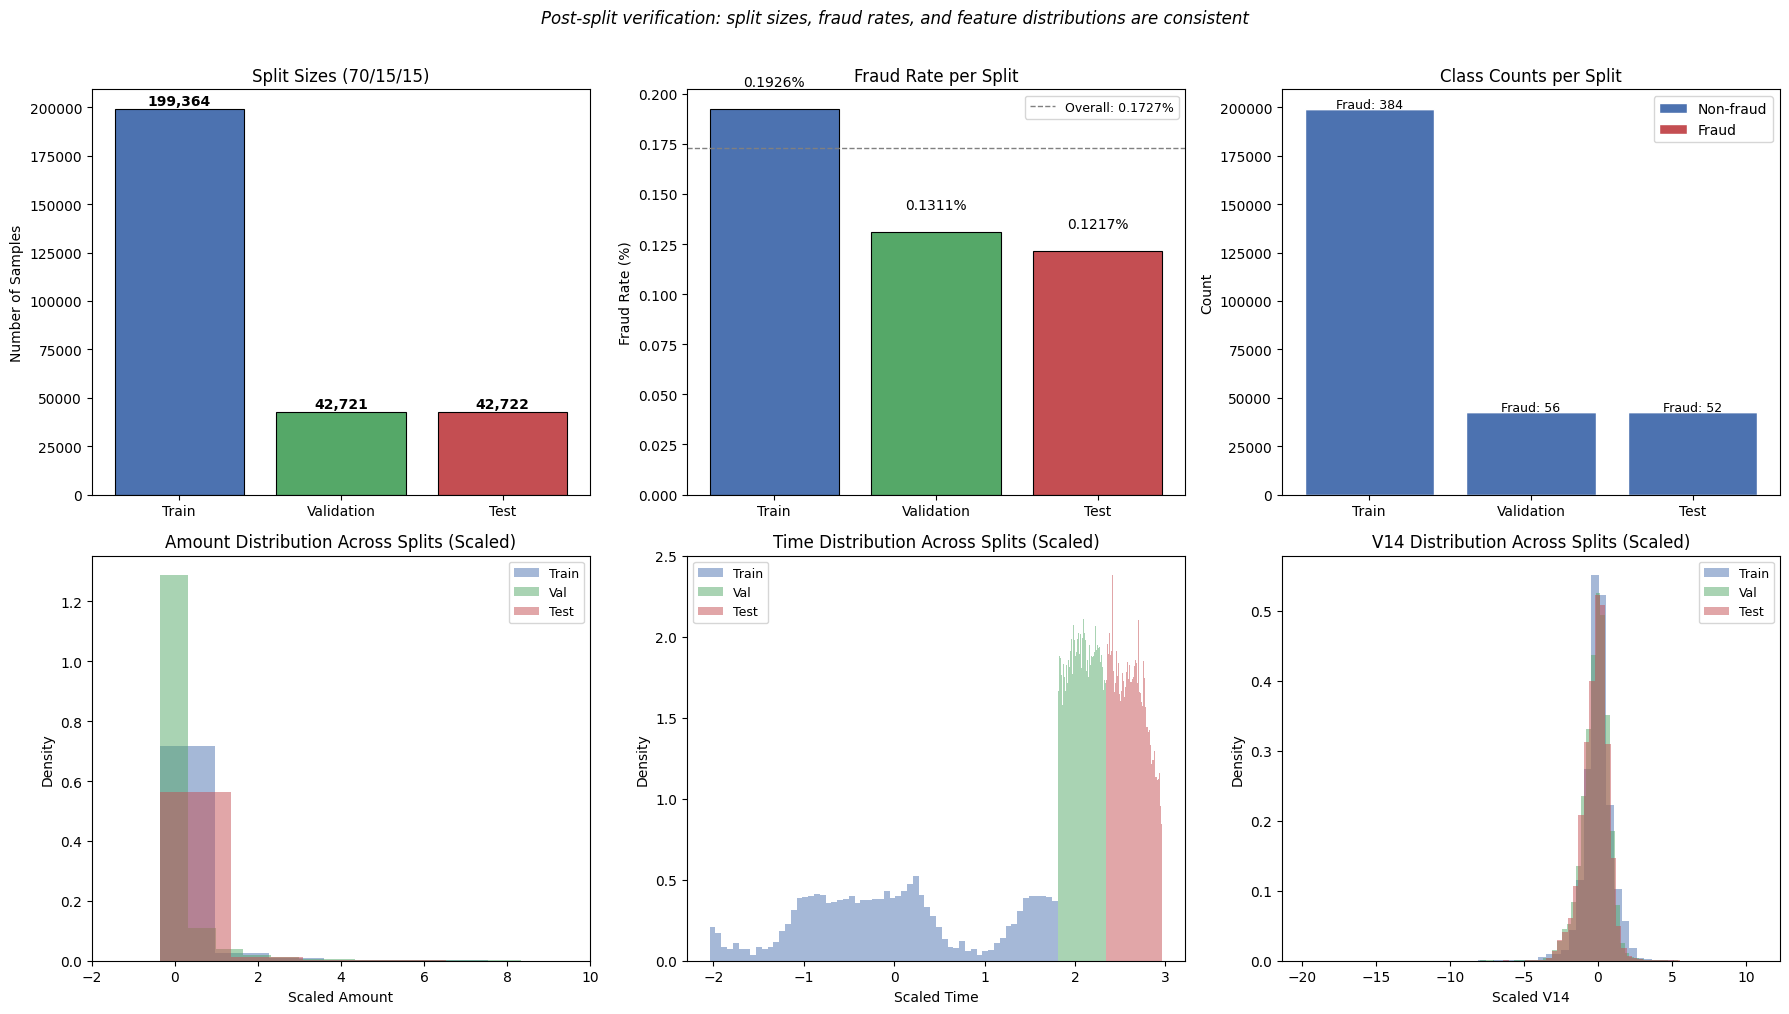

In [11]:
# ---------------------------------------------------------------------------
# Post-split visual checks
# ---------------------------------------------------------------------------
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# --- Row 1: Split-level class distribution ---
split_names = ["Train", "Validation", "Test"]
split_labels = [y_train, y_val, y_test]
split_sizes = [len(y_train), len(y_val), len(y_test)]

# (a) Bar chart of split sizes
bars = axes[0, 0].bar(split_names, split_sizes, color=["#4c72b0", "#55a868", "#c44e52"],
                       edgecolor="black", linewidth=0.8)
for bar, sz in zip(bars, split_sizes):
    axes[0, 0].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 500,
                     f"{sz:,}", ha="center", va="bottom", fontsize=10, fontweight="bold")
axes[0, 0].set_ylabel("Number of Samples")
axes[0, 0].set_title("Split Sizes (70/15/15)")

# (b) Fraud rate per split
fraud_rates = [y.mean() * 100 for y in split_labels]
bar_colors = ["#4c72b0", "#55a868", "#c44e52"]
bars_fr = axes[0, 1].bar(split_names, fraud_rates, color=bar_colors, edgecolor="black", linewidth=0.8)
for bar, fr in zip(bars_fr, fraud_rates):
    axes[0, 1].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01,
                     f"{fr:.4f}%", ha="center", va="bottom", fontsize=10)
axes[0, 1].set_ylabel("Fraud Rate (%)")
axes[0, 1].set_title("Fraud Rate per Split")
axes[0, 1].axhline(y=df["Class"].mean() * 100, color="grey", linestyle="--",
                    label=f"Overall: {df['Class'].mean()*100:.4f}%", linewidth=1)
axes[0, 1].legend(fontsize=9)

# (c) Fraud count per split (stacked)
fraud_counts = [y.sum() for y in split_labels]
legit_counts = [len(y) - y.sum() for y in split_labels]
axes[0, 2].bar(split_names, legit_counts, color="#4c72b0", label="Non-fraud", edgecolor="white")
axes[0, 2].bar(split_names, fraud_counts, bottom=legit_counts, color="#c44e52",
               label="Fraud", edgecolor="white")
axes[0, 2].set_ylabel("Count")
axes[0, 2].set_title("Class Counts per Split")
axes[0, 2].legend()
for i, (fc, name) in enumerate(zip(fraud_counts, split_names)):
    axes[0, 2].text(i, legit_counts[i] + fc + 500, f"Fraud: {fc}", ha="center", fontsize=9)

# --- Row 2: Feature distributions across splits (scaled) ---
# Amount distribution across splits
amount_idx = feature_names.index("Amount")
axes[1, 0].hist(X_train_scaled[:, amount_idx], bins=60, alpha=0.5, color="#4c72b0",
                label="Train", density=True)
axes[1, 0].hist(X_val_scaled[:, amount_idx], bins=60, alpha=0.5, color="#55a868",
                label="Val", density=True)
axes[1, 0].hist(X_test_scaled[:, amount_idx], bins=60, alpha=0.5, color="#c44e52",
                label="Test", density=True)
axes[1, 0].set_xlabel("Scaled Amount")
axes[1, 0].set_ylabel("Density")
axes[1, 0].set_title("Amount Distribution Across Splits (Scaled)")
axes[1, 0].legend(fontsize=9)
axes[1, 0].set_xlim(-2, 10)

# Time distribution across splits
time_idx = feature_names.index("Time")
axes[1, 1].hist(X_train_scaled[:, time_idx], bins=60, alpha=0.5, color="#4c72b0",
                label="Train", density=True)
axes[1, 1].hist(X_val_scaled[:, time_idx], bins=60, alpha=0.5, color="#55a868",
                label="Val", density=True)
axes[1, 1].hist(X_test_scaled[:, time_idx], bins=60, alpha=0.5, color="#c44e52",
                label="Test", density=True)
axes[1, 1].set_xlabel("Scaled Time")
axes[1, 1].set_ylabel("Density")
axes[1, 1].set_title("Time Distribution Across Splits (Scaled)")
axes[1, 1].legend(fontsize=9)

# V14 distribution across splits (one of the most discriminative features)
v14_idx = feature_names.index("V14")
axes[1, 2].hist(X_train_scaled[:, v14_idx], bins=60, alpha=0.5, color="#4c72b0",
                label="Train", density=True)
axes[1, 2].hist(X_val_scaled[:, v14_idx], bins=60, alpha=0.5, color="#55a868",
                label="Val", density=True)
axes[1, 2].hist(X_test_scaled[:, v14_idx], bins=60, alpha=0.5, color="#c44e52",
                label="Test", density=True)
axes[1, 2].set_xlabel("Scaled V14")
axes[1, 2].set_ylabel("Density")
axes[1, 2].set_title("V14 Distribution Across Splits (Scaled)")
axes[1, 2].legend(fontsize=9)

plt.suptitle("Post-split verification: split sizes, fraud rates, and feature distributions are consistent",
             fontsize=12, y=1.01, fontstyle="italic")
plt.tight_layout()
plt.show()

### 5.1 — Trivial baseline: always predict non-fraud

The simplest possible model predicts **class 0** (non-fraud) for every transaction, regardless of its features. This is equivalent to a system that never flags anything.

**What to expect:**

| Metric | Expected value | Why |
| --- | --- | --- |
| Recall | 0 | The model never predicts fraud, so it catches zero fraud cases (all frauds are false negatives). |
| Precision | 0 | There are no positive predictions, so precision is undefined and reported as 0. |
| F1 | 0 | Harmonic mean of two zeros. |
| PR AUC | ~ fraud prevalence (~0.13%) | With constant scores, precision-recall collapses to the positive-class base rate. |

**Why this matters:** In practice, a model with 99.87% accuracy (by predicting all non-fraud) sounds impressive but is completely useless — it misses every single fraud. This demonstrates why accuracy is not a meaningful metric under heavy class imbalance, and why we use PR AUC, recall, and F1 instead.

The cell below computes these metrics on the **validation set** and prints the full confusion matrix so we can see exactly how many fraud cases are missed.

In [12]:
from sklearn.metrics import (
    precision_recall_curve,
    auc,
    f1_score,
    recall_score,
    precision_score,
    confusion_matrix,
)

# ---------------------------------------------------------------------------
# Trivial baseline: predict class 0 (non-fraud) for every sample
# ---------------------------------------------------------------------------
y_val_pred_trivial = np.zeros_like(y_val)          # hard predictions (all 0)
y_val_prob_trivial = np.zeros(len(y_val))           # probability scores (all 0.0)

# Metrics at the trivial decision
print("=== Trivial Baseline (always predict non-fraud) ===")
print(f"Recall:    {recall_score(y_val, y_val_pred_trivial):.4f}")
print(f"Precision: {precision_score(y_val, y_val_pred_trivial, zero_division=0):.4f}")
print(f"F1 Score:  {f1_score(y_val, y_val_pred_trivial):.4f}")

# PR AUC — for a constant predictor, precision = fraud_rate at all recall levels
prec_t, rec_t, _ = precision_recall_curve(y_val, y_val_prob_trivial)
pr_auc_trivial = auc(rec_t, prec_t)
print(f"PR AUC:    {pr_auc_trivial:.4f}")

print("\nConfusion matrix (rows=actual, cols=predicted):")
cm = confusion_matrix(y_val, y_val_pred_trivial)
print(cm)
print(f"\n  TN={cm[0,0]}  FP={cm[0,1]}")
print(f"  FN={cm[1,0]}  TP={cm[1,1]}")
print(f"\n  False-negative rate: {cm[1,0] / max(cm[1].sum(), 1):.4f}")
print(f"  False-positive rate: {cm[0,1] / max(cm[0].sum(), 1):.4f}")

=== Trivial Baseline (always predict non-fraud) ===
Recall:    0.0000
Precision: 0.0000
F1 Score:  0.0000
PR AUC:    0.5007

Confusion matrix (rows=actual, cols=predicted):
[[42665     0]
 [   56     0]]

  TN=42665  FP=0
  FN=56  TP=0

  False-negative rate: 1.0000
  False-positive rate: 0.0000


### 5.2 — Logistic regression baseline

Logistic regression is a classical linear classifier that models the log-odds of the positive class as a linear combination of input features. Despite its simplicity, it is a strong first baseline for tabular data.

**Key configuration choices:**
- **`class_weight="balanced"`**: scikit-learn automatically computes weights inversely proportional to class frequencies. This means each fraud sample contributes far more to the loss than each legitimate sample, forcing the model to pay attention to the minority class without requiring manual weight calculation.
- **`solver="lbfgs"`**: a quasi-Newton optimization method well-suited for small-to-medium datasets with L2 regularization.
- **`max_iter=1000`**: ensures the optimizer has enough iterations to converge on this dataset.
- **`random_state=42`**: fixes the random seed for reproducibility.

**What this baseline tells us:**
- It reveals how much of the fraud signal lives in **linear** combinations of the 30 input features (Time, Amount, V1–V28).
- It provides **calibrated probability scores** out of the box, meaning the predicted probabilities are already roughly aligned with true fraud rates — useful as a calibration reference.
- The gap between logistic regression and the MLP later will show us how much the non-linear layers contribute.

**Evaluation approach:** We use the default threshold of 0.5 for hard predictions and compute the same metrics as the trivial baseline (recall, precision, F1, PR AUC, confusion matrix) so the comparison is apples-to-apples. The threshold will be optimized in Step 7.

In [13]:
from sklearn.linear_model import LogisticRegression

# ---------------------------------------------------------------------------
# Logistic regression baseline (with class weighting for imbalance)
# ---------------------------------------------------------------------------
lr = LogisticRegression(
    class_weight="balanced",   # auto-weight inversely proportional to class freq
    max_iter=1000,
    solver="lbfgs",
    random_state=42,
)
lr.fit(X_train_scaled, y_train)

# Predicted probabilities on the validation set
y_val_prob_lr = lr.predict_proba(X_val_scaled)[:, 1]

# Use a 0.5 default threshold for hard predictions
y_val_pred_lr = (y_val_prob_lr >= 0.5).astype(int)

print("=== Logistic Regression Baseline ===")
print(f"Recall:    {recall_score(y_val, y_val_pred_lr):.4f}")
print(f"Precision: {precision_score(y_val, y_val_pred_lr, zero_division=0):.4f}")
print(f"F1 Score:  {f1_score(y_val, y_val_pred_lr):.4f}")

prec_lr, rec_lr, _ = precision_recall_curve(y_val, y_val_prob_lr)
pr_auc_lr = auc(rec_lr, prec_lr)
print(f"PR AUC:    {pr_auc_lr:.4f}")

print("\nConfusion matrix (rows=actual, cols=predicted):")
cm_lr = confusion_matrix(y_val, y_val_pred_lr)
print(cm_lr)
print(f"\n  TN={cm_lr[0,0]}  FP={cm_lr[0,1]}")
print(f"  FN={cm_lr[1,0]}  TP={cm_lr[1,1]}")
print(f"\n  False-negative rate: {cm_lr[1,0] / max(cm_lr[1].sum(), 1):.4f}")
print(f"  False-positive rate: {cm_lr[0,1] / max(cm_lr[0].sum(), 1):.4f}")

=== Logistic Regression Baseline ===
Recall:    0.9286
Precision: 0.0531
F1 Score:  0.1004
PR AUC:    0.8389

Confusion matrix (rows=actual, cols=predicted):
[[41737   928]
 [    4    52]]

  TN=41737  FP=928
  FN=4  TP=52

  False-negative rate: 0.0714
  False-positive rate: 0.0218


### 5.3 — Starting model: feedforward MLP

The MLP is the starting deep-learning model. It builds on the logistic regression baseline by adding **non-linear hidden layers** that can capture interactions and complex decision boundaries that a linear model cannot.

#### Architecture overview

The network takes 30 input features and passes them through three progressively narrower hidden layers before producing a single fraud probability:

```
Input (30) → Dense(128) → Dropout(0.4) → Dense(64) → Dropout(0.3) → Dense(32) → Dropout(0.3) → Dense(1, sigmoid)
```

#### Design decisions explained

| Component | Choice | Rationale |
|---|---|---|
| **Hidden layers** | 3 Dense layers (128 → 64 → 32) | A "funnel" shape that progressively compresses information. 128 units in the first layer gives enough capacity to capture feature interactions; narrowing to 32 forces the network to distill the most discriminative patterns. Three layers is a moderate depth — enough for non-linearity without excessive risk of overfitting on ~200k training samples. |
| **Activation** | ReLU (Rectified Linear Unit) | Standard default for hidden layers. ReLU outputs `max(0, x)`, which avoids the vanishing gradient problem that plagues sigmoid/tanh in deep networks, and is computationally cheap. |
| **Regularization** | Dropout (0.4 on first layer, 0.3 on others) | During each training step, Dropout randomly sets a fraction of neuron outputs to zero. This prevents neurons from co-adapting (relying on specific other neurons) and acts as an ensemble of thinned networks. The first layer gets higher dropout (0.4) because it has the most parameters. |
| **Output layer** | 1 unit with sigmoid activation | Sigmoid squashes the output to [0, 1], directly interpretable as a fraud probability. A single unit is standard for binary classification. |
| **Loss function** | Binary cross-entropy with class weights | Cross-entropy measures how well the predicted probabilities match the true labels. The `class_weight` dictionary (computed in Step 4) multiplies the loss for fraud samples by ~518×, ensuring the network does not simply learn to predict all-zero. |
| **Optimizer** | Adam (learning rate = 1e-3) | Adam combines momentum and adaptive per-parameter learning rates. The default lr of 1e-3 is a well-tested starting point for tabular data. |
| **Early stopping** | Monitor `val_loss`, patience = 10, restore best weights | Training stops if validation loss does not improve for 10 consecutive epochs, and the model reverts to the weights from the best epoch. This prevents overfitting without requiring manual epoch selection. |

#### Why this specific size?

- **Too small** (e.g., a single 16-unit layer) may underfit: the model cannot capture enough non-linear structure.
- **Too large** (e.g., 512 → 256 → 128) risks overfitting on a dataset where only ~384 fraud cases exist in the training set.
- The 128 → 64 → 32 configuration is a deliberate middle ground, and Step 7 will experiment with variations.

The cell below defines the `build_mlp` function, instantiates the model, compiles it, and prints the architecture summary (layer types, output shapes, and parameter counts).

In [14]:
import random, os
import tensorflow as tf

# Use attribute access (more reliable across TF versions than 'from tensorflow.keras import ...')
keras = tf.keras
layers = tf.keras.layers

# ---------------------------------------------------------------------------
# Reproducibility: set all random seeds
# ---------------------------------------------------------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

# ---------------------------------------------------------------------------
# Build the starting MLP
# ---------------------------------------------------------------------------
def build_mlp(input_dim: int, name: str = "fraud_mlp") -> keras.Model:
    """Small-to-medium feedforward MLP for binary fraud classification."""
    model = keras.Sequential(
        [
            layers.Input(shape=(input_dim,)),
            layers.Dense(128, activation="relu"),
            layers.Dropout(0.4),
            layers.Dense(64, activation="relu"),
            layers.Dropout(0.3),
            layers.Dense(32, activation="relu"),
            layers.Dropout(0.3),
            layers.Dense(1, activation="sigmoid"),
        ],
        name=name,
    )
    return model

input_dim = X_train_scaled.shape[1]
mlp = build_mlp(input_dim)

mlp.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=["AUC"],       # ROC-AUC tracked during training for quick reference
)

mlp.summary()

2026-02-09 05:49:24.477335: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-09 05:49:24.478171: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-09 05:49:24.527055: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX512_FP16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2026-02-09 05:49:25.409241: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-09 05:49:25.409728: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-09 05:49:25.559290: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "fraud_mlp"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         3,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,337 (56.00 KB)

 Trainable params: 14,337 (56.00 KB)

 Non-trainable params: 0 (0.00 B)

### 5.4 — Train the starting MLP

This cell runs the actual training loop. Here is what happens under the hood at each epoch:

1. **Forward pass**: the training data is fed through the network in mini-batches of 2,048 samples. For each sample, the network produces a fraud probability.
2. **Loss computation**: binary cross-entropy is calculated between the predicted probabilities and the true labels. Each fraud sample's loss is multiplied by the `class_weight[1]` (~518×) so that missing a fraud case is penalized far more heavily than a false alarm.
3. **Backward pass**: gradients of the loss with respect to every weight are computed via backpropagation.
4. **Weight update**: the Adam optimizer uses these gradients (plus its momentum and adaptive learning rate state) to update the network's weights.
5. **Validation check**: after each epoch, the model is evaluated on the validation set (without Dropout) and `val_loss` is recorded.

**Early stopping** watches `val_loss`:
- If `val_loss` improves (decreases), the current weights are saved internally as the "best so far."
- If `val_loss` does not improve for 10 consecutive epochs (`patience=10`), training halts early and the model's weights are **reverted** to the best checkpoint. This means the final model is not the one from the last epoch, but from the epoch with the lowest validation loss.

**Batch size = 2,048**: a relatively large batch for this dataset size. Larger batches give more stable gradient estimates per step and train faster on GPU, but can sometimes converge to sharper minima. This is a reasonable default for ~200k training samples.

**Max epochs = 100**: an upper bound. In practice, early stopping typically triggers well before 100 epochs.

The training cell is followed by a plotting cell that visualizes the loss and ROC-AUC curves over epochs, so you can visually confirm that (a) training loss decreases, (b) validation loss eventually plateaus or rises (triggering early stopping), and (c) there is no severe divergence between train and val curves (which would indicate overfitting).

In [15]:
# ---------------------------------------------------------------------------
# Train the MLP with early stopping
# ---------------------------------------------------------------------------
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
    verbose=1,
)

history = mlp.fit(
    X_train_scaled,
    y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=100,
    batch_size=2048,
    class_weight=class_weight,
    callbacks=[early_stop],
    verbose=1,
)

Epoch 1/100


 1/98 ━━━━━━━━━━━━━━━━━━━━ 1:29 925ms/step - AUC: 0.9118 - loss: 1.1329

11/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.8377 - loss: 1.1020    

21/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.8094 - loss: 1.0870

33/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.8122 - loss: 1.0507

44/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.8235 - loss: 1.0137

56/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.8380 - loss: 0.9774

67/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.8479 - loss: 0.9512

79/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.8575 - loss: 0.9225

91/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.8657 - loss: 0.8964

98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - AUC: 0.9275 - loss: 0.6876 - val_AUC: 0.9578 - val_loss: 0.1588


Epoch 2/100


 1/98 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - AUC: 0.8529 - loss: 0.5963

12/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9371 - loss: 0.4404 

23/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9339 - loss: 0.4702

35/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9364 - loss: 0.4731

46/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9391 - loss: 0.4711

58/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9432 - loss: 0.4635

70/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9457 - loss: 0.4612

82/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9480 - loss: 0.4559

94/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9497 - loss: 0.4540

98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9620 - loss: 0.4357 - val_AUC: 0.9773 - val_loss: 0.0935


Epoch 3/100


 1/98 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - AUC: 0.9976 - loss: 0.1911

13/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9543 - loss: 0.4248 

23/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9504 - loss: 0.4532

34/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9523 - loss: 0.4472

46/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9543 - loss: 0.4395

58/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9573 - loss: 0.4274

70/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9585 - loss: 0.4268

83/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9597 - loss: 0.4231

94/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9605 - loss: 0.4207

98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9673 - loss: 0.3944 - val_AUC: 0.9788 - val_loss: 0.1067


Epoch 4/100


 1/98 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - AUC: 0.9983 - loss: 0.1789

13/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9819 - loss: 0.2727 

25/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9761 - loss: 0.3058

35/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9767 - loss: 0.3065

47/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9773 - loss: 0.3080

57/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9783 - loss: 0.3070

68/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9787 - loss: 0.3098

80/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9790 - loss: 0.3103

92/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9795 - loss: 0.3093

98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9838 - loss: 0.2974 - val_AUC: 0.9776 - val_loss: 0.0804


Epoch 5/100


 1/98 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - AUC: 0.9988 - loss: 0.1376

14/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9870 - loss: 0.2357   

25/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9806 - loss: 0.2814

36/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9801 - loss: 0.2897

47/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9805 - loss: 0.2925

60/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9813 - loss: 0.2920

71/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9810 - loss: 0.2968

83/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9810 - loss: 0.2975

94/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9812 - loss: 0.2969

98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9830 - loss: 0.2881 - val_AUC: 0.9789 - val_loss: 0.0552


Epoch 6/100


 1/98 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - AUC: 0.9972 - loss: 0.1705

13/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9861 - loss: 0.2551 

24/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9845 - loss: 0.2710

35/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9852 - loss: 0.2674

47/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9860 - loss: 0.2652

59/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9869 - loss: 0.2614

71/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9872 - loss: 0.2627

83/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9874 - loss: 0.2621

95/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9875 - loss: 0.2623

98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9885 - loss: 0.2595 - val_AUC: 0.9769 - val_loss: 0.0646


Epoch 7/100


 1/98 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - AUC: 0.9973 - loss: 0.1674

13/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9914 - loss: 0.2224 

24/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9883 - loss: 0.2445

36/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9884 - loss: 0.2445

47/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9886 - loss: 0.2447

57/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9888 - loss: 0.2456

69/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9884 - loss: 0.2524

80/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9881 - loss: 0.2557

91/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9876 - loss: 0.2616

98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9840 - loss: 0.3120 - val_AUC: 0.9788 - val_loss: 0.0690


Epoch 8/100


 1/98 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - AUC: 0.9990 - loss: 0.1425

12/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9748 - loss: 0.3008 

23/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9715 - loss: 0.3279

35/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9737 - loss: 0.3199

46/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9757 - loss: 0.3125

57/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9776 - loss: 0.3050

68/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9784 - loss: 0.3047

80/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9790 - loss: 0.3031

93/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9796 - loss: 0.3011

98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9842 - loss: 0.2818 - val_AUC: 0.9802 - val_loss: 0.0694


Epoch 9/100


 1/98 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - AUC: 0.9987 - loss: 0.1394

13/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9888 - loss: 0.2292 

24/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9883 - loss: 0.2364

35/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9893 - loss: 0.2300

48/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9904 - loss: 0.2227

59/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9911 - loss: 0.2180

71/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9909 - loss: 0.2207

82/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9908 - loss: 0.2215

93/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9908 - loss: 0.2221

98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9909 - loss: 0.2223 - val_AUC: 0.9804 - val_loss: 0.0434


Epoch 10/100


 1/98 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - AUC: 0.9988 - loss: 0.1239

13/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9945 - loss: 0.1831 

24/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9916 - loss: 0.2135

35/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9914 - loss: 0.2164

47/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9915 - loss: 0.2172

58/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9919 - loss: 0.2149

69/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9919 - loss: 0.2169

81/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9919 - loss: 0.2176

93/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9919 - loss: 0.2176

98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9923 - loss: 0.2134 - val_AUC: 0.9687 - val_loss: 0.0383


Epoch 11/100


 1/98 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - AUC: 0.9990 - loss: 0.1071

12/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9973 - loss: 0.1384 

22/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9959 - loss: 0.1523

33/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9957 - loss: 0.1526

44/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9957 - loss: 0.1540

55/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9958 - loss: 0.1539

66/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9958 - loss: 0.1561

77/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9958 - loss: 0.1585

88/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9957 - loss: 0.1605

98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.9944 - loss: 0.1827 - val_AUC: 0.9640 - val_loss: 0.0314


Epoch 12/100


 1/98 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - AUC: 0.9967 - loss: 0.1261

14/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9897 - loss: 0.2356 

24/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9878 - loss: 0.2509

36/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9884 - loss: 0.2435

47/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9884 - loss: 0.2440

58/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9885 - loss: 0.2441

70/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9885 - loss: 0.2455

82/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9886 - loss: 0.2454

93/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9887 - loss: 0.2442

98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9899 - loss: 0.2338 - val_AUC: 0.9636 - val_loss: 0.0308


Epoch 13/100


 1/98 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - AUC: 0.9984 - loss: 0.1235

13/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9969 - loss: 0.1539 

23/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9954 - loss: 0.1702

34/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9952 - loss: 0.1718

45/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9947 - loss: 0.1784

56/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9946 - loss: 0.1815

69/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9945 - loss: 0.1851

81/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9944 - loss: 0.1875

92/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9942 - loss: 0.1897

98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9932 - loss: 0.2019 - val_AUC: 0.9636 - val_loss: 0.0360


Epoch 14/100


 1/98 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - AUC: 0.9983 - loss: 0.1182

12/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9947 - loss: 0.1629 

23/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9935 - loss: 0.1799

35/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9939 - loss: 0.1762

47/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9944 - loss: 0.1725

59/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9948 - loss: 0.1700

72/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9950 - loss: 0.1695

82/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9952 - loss: 0.1687

93/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9953 - loss: 0.1686

98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9960 - loss: 0.1664 - val_AUC: 0.9655 - val_loss: 0.0314


Epoch 15/100


 1/98 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - AUC: 0.9995 - loss: 0.0848

12/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9962 - loss: 0.1299 

23/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9938 - loss: 0.1622

33/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9934 - loss: 0.1691

46/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9936 - loss: 0.1706

56/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9939 - loss: 0.1701

67/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9939 - loss: 0.1738

78/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9938 - loss: 0.1765

89/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9937 - loss: 0.1786

98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9925 - loss: 0.2010 - val_AUC: 0.9640 - val_loss: 0.0332


Epoch 16/100


 1/98 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - AUC: 0.9923 - loss: 0.2110

12/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9961 - loss: 0.1606 

24/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9957 - loss: 0.1647

35/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9956 - loss: 0.1640

45/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9958 - loss: 0.1624

57/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9960 - loss: 0.1604

68/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9960 - loss: 0.1610

78/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9961 - loss: 0.1613

88/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9961 - loss: 0.1620

98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9961 - loss: 0.1681 - val_AUC: 0.9646 - val_loss: 0.0374


Epoch 17/100


 1/98 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - AUC: 0.9984 - loss: 0.1339

11/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9961 - loss: 0.1592 

22/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9957 - loss: 0.1666

33/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9959 - loss: 0.1639

44/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9961 - loss: 0.1619

56/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9963 - loss: 0.1592

68/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9964 - loss: 0.1589

80/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9965 - loss: 0.1580

91/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9965 - loss: 0.1574

98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9965 - loss: 0.1558 - val_AUC: 0.9593 - val_loss: 0.0235


Epoch 18/100


 1/98 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - AUC: 0.9993 - loss: 0.1000

13/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9944 - loss: 0.1621 

24/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9936 - loss: 0.1774

36/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9941 - loss: 0.1729

47/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9945 - loss: 0.1679

58/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9950 - loss: 0.1632

69/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9952 - loss: 0.1613

81/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9954 - loss: 0.1593

93/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9956 - loss: 0.1575

98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9969 - loss: 0.1449 - val_AUC: 0.9597 - val_loss: 0.0185


Epoch 19/100


 1/98 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - AUC: 0.9993 - loss: 0.0786

13/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9953 - loss: 0.1335 

23/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9945 - loss: 0.1517

34/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9948 - loss: 0.1509

46/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9950 - loss: 0.1502

58/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9954 - loss: 0.1482

69/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9955 - loss: 0.1491

79/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9956 - loss: 0.1490

91/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9956 - loss: 0.1494

98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9953 - loss: 0.1520 - val_AUC: 0.9598 - val_loss: 0.0160


Epoch 20/100


 1/98 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - AUC: 0.9990 - loss: 0.0913

12/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9952 - loss: 0.1619 

23/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9941 - loss: 0.1850

34/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9940 - loss: 0.1858

44/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9943 - loss: 0.1827

55/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9946 - loss: 0.1788

67/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9948 - loss: 0.1776

78/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9949 - loss: 0.1763

89/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9950 - loss: 0.1751

98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9954 - loss: 0.1706 - val_AUC: 0.9604 - val_loss: 0.0211


Epoch 21/100


 1/98 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - AUC: 0.9951 - loss: 0.1292

13/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9956 - loss: 0.1592 

24/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9957 - loss: 0.1603

36/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9961 - loss: 0.1531

48/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9965 - loss: 0.1468

59/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9967 - loss: 0.1422

68/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9968 - loss: 0.1425

80/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9968 - loss: 0.1433

93/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9968 - loss: 0.1436

98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9969 - loss: 0.1443 - val_AUC: 0.9665 - val_loss: 0.0338


Epoch 22/100


 1/98 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - AUC: 0.9993 - loss: 0.1007

11/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9961 - loss: 0.1493 

24/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9952 - loss: 0.1655

36/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9954 - loss: 0.1617

48/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9957 - loss: 0.1573

60/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9960 - loss: 0.1532

73/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9962 - loss: 0.1515

85/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9963 - loss: 0.1499

97/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9964 - loss: 0.1485

98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9973 - loss: 0.1353 - val_AUC: 0.9605 - val_loss: 0.0178


Epoch 23/100


 1/98 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - AUC: 0.9988 - loss: 0.0824

15/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9979 - loss: 0.1115 

28/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9974 - loss: 0.1243

41/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9974 - loss: 0.1254

54/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9973 - loss: 0.1283

66/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9973 - loss: 0.1301

79/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9973 - loss: 0.1311

92/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9973 - loss: 0.1313

98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9974 - loss: 0.1314 - val_AUC: 0.9610 - val_loss: 0.0172


Epoch 24/100


 1/98 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - AUC: 0.9989 - loss: 0.0872

14/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9975 - loss: 0.1141 

24/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9967 - loss: 0.1358

35/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9966 - loss: 0.1390

46/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9964 - loss: 0.1427

57/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9964 - loss: 0.1439

67/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9965 - loss: 0.1446

78/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9965 - loss: 0.1448

88/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9965 - loss: 0.1449

98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.9969 - loss: 0.1400 - val_AUC: 0.9600 - val_loss: 0.0305


Epoch 25/100


 1/98 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - AUC: 0.9976 - loss: 0.1036

13/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9962 - loss: 0.1385 

25/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9961 - loss: 0.1409

35/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9963 - loss: 0.1390

46/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9965 - loss: 0.1373

57/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9967 - loss: 0.1347

68/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9968 - loss: 0.1338

79/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9969 - loss: 0.1330

90/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9970 - loss: 0.1329

98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.9975 - loss: 0.1280 - val_AUC: 0.9608 - val_loss: 0.0206


Epoch 26/100


 1/98 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - AUC: 0.9988 - loss: 0.0794

13/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9975 - loss: 0.1154 

25/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9973 - loss: 0.1253

37/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9974 - loss: 0.1234

49/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9976 - loss: 0.1202

61/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9977 - loss: 0.1188

72/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9977 - loss: 0.1186

83/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9978 - loss: 0.1182

95/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9978 - loss: 0.1177

98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9981 - loss: 0.1115 - val_AUC: 0.9612 - val_loss: 0.0169


Epoch 27/100


 1/98 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - AUC: 0.9993 - loss: 0.0618

12/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9973 - loss: 0.1217 

24/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9976 - loss: 0.1167

34/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9977 - loss: 0.1137

46/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9978 - loss: 0.1144

57/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9976 - loss: 0.1192

68/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9971 - loss: 0.1268

79/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9969 - loss: 0.1314

89/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9967 - loss: 0.1338

98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.9958 - loss: 0.1480 - val_AUC: 0.9600 - val_loss: 0.0226


Epoch 28/100


 1/98 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - AUC: 0.9985 - loss: 0.0909

13/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9985 - loss: 0.0954 

23/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9986 - loss: 0.0933

34/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9986 - loss: 0.0927

45/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9986 - loss: 0.0930

56/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9987 - loss: 0.0930

67/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9986 - loss: 0.0949

78/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9986 - loss: 0.0965

90/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9986 - loss: 0.0977

98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9984 - loss: 0.1035 - val_AUC: 0.9605 - val_loss: 0.0212


Epoch 29/100


 1/98 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - AUC: 0.9985 - loss: 0.1041

13/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9986 - loss: 0.0906 

25/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9987 - loss: 0.0889

36/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9986 - loss: 0.0908

48/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9986 - loss: 0.0915

59/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9986 - loss: 0.0921

69/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9986 - loss: 0.0928

81/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9986 - loss: 0.0935

92/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9986 - loss: 0.0940

98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9984 - loss: 0.1008 - val_AUC: 0.9616 - val_loss: 0.0153


Epoch 30/100


 1/98 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - AUC: 0.9954 - loss: 0.1340

13/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9981 - loss: 0.0972 

24/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9982 - loss: 0.0977

35/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9983 - loss: 0.0981

45/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9983 - loss: 0.0979

56/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9983 - loss: 0.0979

67/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9984 - loss: 0.0986

79/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9984 - loss: 0.0989

89/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9983 - loss: 0.0993

98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9983 - loss: 0.1027 - val_AUC: 0.9620 - val_loss: 0.0154


Epoch 31/100


 1/98 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - AUC: 0.9995 - loss: 0.0802

12/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9976 - loss: 0.1153 

23/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9977 - loss: 0.1136

34/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9979 - loss: 0.1078

46/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9980 - loss: 0.1050

57/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9981 - loss: 0.1048

70/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9977 - loss: 0.1096

81/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9975 - loss: 0.1124

92/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9974 - loss: 0.1138

98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9966 - loss: 0.1197 - val_AUC: 0.9617 - val_loss: 0.0145


Epoch 32/100


 1/98 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - AUC: 0.9989 - loss: 0.0686

12/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9983 - loss: 0.0889 

23/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9982 - loss: 0.0953

34/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9983 - loss: 0.0943

45/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9983 - loss: 0.0951

56/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9984 - loss: 0.0947

68/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9984 - loss: 0.0964

78/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9984 - loss: 0.0971

89/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9984 - loss: 0.0973

98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9982 - loss: 0.1039 - val_AUC: 0.9623 - val_loss: 0.0121


Epoch 33/100


 1/98 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - AUC: 0.9991 - loss: 0.0751

13/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9992 - loss: 0.0720 

24/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9990 - loss: 0.0763

35/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9990 - loss: 0.0772

46/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9990 - loss: 0.0774

57/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9990 - loss: 0.0785

69/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9989 - loss: 0.0812

80/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9989 - loss: 0.0830

91/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9988 - loss: 0.0844

98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9985 - loss: 0.0947 - val_AUC: 0.9619 - val_loss: 0.0143


Epoch 34/100


 1/98 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - AUC: 0.9993 - loss: 0.0664

13/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9989 - loss: 0.0761 

14/98 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - AUC: 0.9988 - loss: 0.0765

23/98 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - AUC: 0.9987 - loss: 0.0822

35/98 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - AUC: 0.9987 - loss: 0.0830

45/98 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.9987 - loss: 0.0838

56/98 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.9987 - loss: 0.0849 

67/98 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.9986 - loss: 0.0867

78/98 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.9986 - loss: 0.0885

89/98 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9986 - loss: 0.0897

98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - AUC: 0.9984 - loss: 0.0974 - val_AUC: 0.9616 - val_loss: 0.0165


Epoch 35/100


 1/98 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - AUC: 0.9987 - loss: 0.0676

12/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9991 - loss: 0.0685 

24/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9991 - loss: 0.0687

35/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9990 - loss: 0.0723

46/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9990 - loss: 0.0739

57/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9990 - loss: 0.0751

68/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9989 - loss: 0.0777

80/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9989 - loss: 0.0796

91/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9989 - loss: 0.0810

98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9986 - loss: 0.0930 - val_AUC: 0.9537 - val_loss: 0.0114


Epoch 36/100


 1/98 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - AUC: 0.9993 - loss: 0.0611

12/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9988 - loss: 0.0804 

23/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9986 - loss: 0.0864

34/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9986 - loss: 0.0894

46/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9986 - loss: 0.0906

59/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9986 - loss: 0.0905

71/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9986 - loss: 0.0903

83/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9986 - loss: 0.0897

95/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9986 - loss: 0.0893

98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9987 - loss: 0.0863 - val_AUC: 0.9541 - val_loss: 0.0092


Epoch 37/100


 1/98 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - AUC: 0.9969 - loss: 0.1092

13/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9981 - loss: 0.0902 

25/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9981 - loss: 0.0968

36/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9982 - loss: 0.0960

47/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9983 - loss: 0.0944

58/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9983 - loss: 0.0927

70/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9984 - loss: 0.0924

82/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9984 - loss: 0.0918

93/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9984 - loss: 0.0912

98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9986 - loss: 0.0856 - val_AUC: 0.9542 - val_loss: 0.0100


Epoch 38/100


 1/98 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - AUC: 0.9971 - loss: 0.1032

13/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9981 - loss: 0.0957 

25/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9982 - loss: 0.0944

36/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9983 - loss: 0.0923

48/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9984 - loss: 0.0894

59/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9984 - loss: 0.0889

70/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9985 - loss: 0.0893

82/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9985 - loss: 0.0896

92/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9985 - loss: 0.0908

98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9983 - loss: 0.0981 - val_AUC: 0.9619 - val_loss: 0.0201


Epoch 39/100


 1/98 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - AUC: 0.9989 - loss: 0.0872

12/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9983 - loss: 0.0917 

23/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9982 - loss: 0.0944

35/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9982 - loss: 0.0941

47/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9983 - loss: 0.0931

58/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9983 - loss: 0.0924

69/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9983 - loss: 0.0932

80/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9983 - loss: 0.0933

92/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9984 - loss: 0.0930

98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9986 - loss: 0.0881 - val_AUC: 0.9540 - val_loss: 0.0115


Epoch 40/100


 1/98 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - AUC: 0.9973 - loss: 0.0937

12/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9984 - loss: 0.0806 

24/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9985 - loss: 0.0805

35/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9987 - loss: 0.0770

47/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9988 - loss: 0.0740

59/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9989 - loss: 0.0729

71/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9989 - loss: 0.0740

82/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9989 - loss: 0.0746

94/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9988 - loss: 0.0750

98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9988 - loss: 0.0771 - val_AUC: 0.9623 - val_loss: 0.0158


Epoch 41/100


 1/98 ━━━━━━━━━━━━━━━━━━━━ 10s 110ms/step - AUC: 0.9991 - loss: 0.0524

12/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9984 - loss: 0.0855   

23/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9985 - loss: 0.0814

34/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9986 - loss: 0.0786

44/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9986 - loss: 0.0791

55/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9987 - loss: 0.0792

66/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9987 - loss: 0.0805

78/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9986 - loss: 0.0817

90/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9986 - loss: 0.0824

98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9985 - loss: 0.0857 - val_AUC: 0.9626 - val_loss: 0.0136


Epoch 42/100


 1/98 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - AUC: 0.9982 - loss: 0.0797

13/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9983 - loss: 0.0881 

24/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9982 - loss: 0.0941

36/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9983 - loss: 0.0920

48/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9984 - loss: 0.0889

60/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9984 - loss: 0.0876

71/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9985 - loss: 0.0878

81/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9985 - loss: 0.0875

93/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9985 - loss: 0.0871

98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9986 - loss: 0.0867 - val_AUC: 0.9621 - val_loss: 0.0139


Epoch 43/100


 1/98 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - AUC: 0.9985 - loss: 0.0688

13/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9993 - loss: 0.0601 

24/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9991 - loss: 0.0691

35/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9991 - loss: 0.0702

46/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9991 - loss: 0.0700

57/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9991 - loss: 0.0700

69/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9991 - loss: 0.0710

81/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9990 - loss: 0.0716

92/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9990 - loss: 0.0718

98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9990 - loss: 0.0702 - val_AUC: 0.9455 - val_loss: 0.0082


Epoch 44/100


 1/98 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - AUC: 0.9988 - loss: 0.0500

13/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9995 - loss: 0.0417 

24/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9994 - loss: 0.0501

35/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9993 - loss: 0.0556

46/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9992 - loss: 0.0603

56/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9992 - loss: 0.0629

68/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9991 - loss: 0.0658

80/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9991 - loss: 0.0675

91/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9990 - loss: 0.0703

98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9985 - loss: 0.0932 - val_AUC: 0.9542 - val_loss: 0.0101


Epoch 45/100


 1/98 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - AUC: 0.9995 - loss: 0.0701

13/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9991 - loss: 0.0714 

23/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9992 - loss: 0.0672

34/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9992 - loss: 0.0672

45/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9991 - loss: 0.0712

57/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9991 - loss: 0.0735

69/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9990 - loss: 0.0749

80/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9990 - loss: 0.0754

92/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9990 - loss: 0.0756

98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9989 - loss: 0.0763 - val_AUC: 0.9453 - val_loss: 0.0099


Epoch 46/100


 1/98 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - AUC: 0.9982 - loss: 0.0655

12/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9991 - loss: 0.0565 

23/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9991 - loss: 0.0580

34/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9992 - loss: 0.0577

46/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9992 - loss: 0.0580

57/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9992 - loss: 0.0597

69/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9991 - loss: 0.0632

81/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9991 - loss: 0.0655

93/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9991 - loss: 0.0672

98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9988 - loss: 0.0802 - val_AUC: 0.9540 - val_loss: 0.0124


Epoch 47/100


 1/98 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - AUC: 0.9995 - loss: 0.0685

14/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9986 - loss: 0.0825 

25/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9985 - loss: 0.0865

35/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9985 - loss: 0.0862

46/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9986 - loss: 0.0851

58/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9986 - loss: 0.0854

70/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9985 - loss: 0.0882

82/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9985 - loss: 0.0894

93/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9985 - loss: 0.0905

98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9984 - loss: 0.0963 - val_AUC: 0.9533 - val_loss: 0.0160


Epoch 48/100


 1/98 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - AUC: 0.9949 - loss: 0.1185

13/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9979 - loss: 0.0875 

24/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9983 - loss: 0.0814

35/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9985 - loss: 0.0779

47/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9987 - loss: 0.0750

58/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9988 - loss: 0.0738

69/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9988 - loss: 0.0740

81/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9988 - loss: 0.0743

91/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9988 - loss: 0.0749

98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9988 - loss: 0.0774 - val_AUC: 0.9533 - val_loss: 0.0150


Epoch 49/100


 1/98 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - AUC: 0.9991 - loss: 0.0596

12/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9992 - loss: 0.0584 

23/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9990 - loss: 0.0659

35/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9990 - loss: 0.0677

46/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9990 - loss: 0.0683

57/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9990 - loss: 0.0687

67/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9990 - loss: 0.0697

78/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9990 - loss: 0.0704

88/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9990 - loss: 0.0707

98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9990 - loss: 0.0704 - val_AUC: 0.9451 - val_loss: 0.0112


Epoch 50/100


 1/98 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - AUC: 0.9988 - loss: 0.0665

13/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9992 - loss: 0.0550 

24/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9991 - loss: 0.0576

35/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9991 - loss: 0.0582

46/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9992 - loss: 0.0575

58/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9992 - loss: 0.0564

69/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9992 - loss: 0.0563

80/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9992 - loss: 0.0561

92/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9992 - loss: 0.0564

98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9992 - loss: 0.0577 - val_AUC: 0.9453 - val_loss: 0.0109


Epoch 51/100


 1/98 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - AUC: 0.9993 - loss: 0.0475

13/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9991 - loss: 0.0553 

25/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9992 - loss: 0.0531

36/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9992 - loss: 0.0528

47/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9992 - loss: 0.0538

58/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9992 - loss: 0.0550

70/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9992 - loss: 0.0562

81/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9992 - loss: 0.0571

92/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9992 - loss: 0.0580

98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9990 - loss: 0.0688 - val_AUC: 0.9453 - val_loss: 0.0106


Epoch 52/100


 1/98 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - AUC: 0.9993 - loss: 0.0629

13/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9983 - loss: 0.0755 

24/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9985 - loss: 0.0717

36/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9986 - loss: 0.0739

48/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9986 - loss: 0.0763

59/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9986 - loss: 0.0775

70/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9986 - loss: 0.0799

81/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9986 - loss: 0.0810

93/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9986 - loss: 0.0819

98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9986 - loss: 0.0859 - val_AUC: 0.9446 - val_loss: 0.0124


Epoch 53/100


 1/98 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - AUC: 0.9993 - loss: 0.0710

13/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9988 - loss: 0.0734 

24/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9989 - loss: 0.0717

35/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9989 - loss: 0.0694

46/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9990 - loss: 0.0689

57/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9989 - loss: 0.0717

68/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9989 - loss: 0.0739

79/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9989 - loss: 0.0752

90/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9989 - loss: 0.0756

98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9989 - loss: 0.0755 - val_AUC: 0.9449 - val_loss: 0.0104


Epoch 53: early stopping


Restoring model weights from the end of the best epoch: 43.


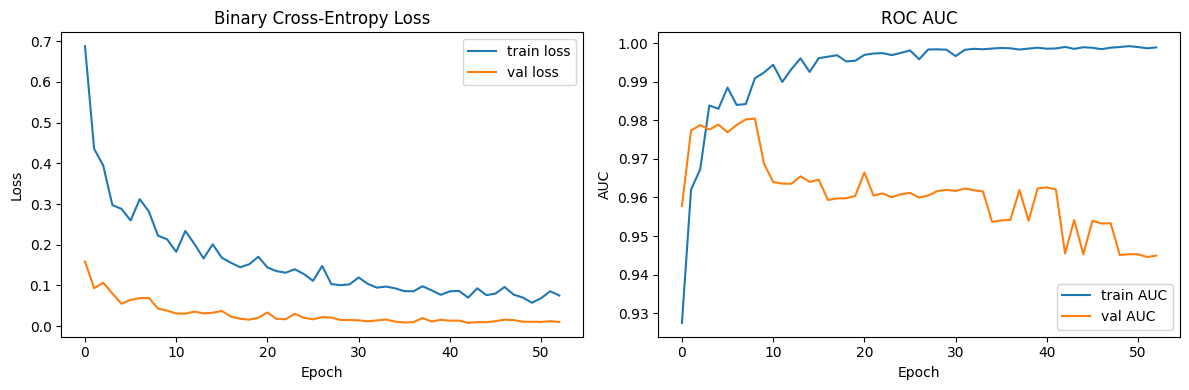

Best epoch (lowest val_loss): 43
  train loss: 0.0702  |  val loss: 0.0082
  train AUC:  0.9990  |  val AUC:  0.9455


In [16]:
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------------
# Plot training curves
# ---------------------------------------------------------------------------
# Detect the AUC key name (varies across TensorFlow versions: "auc", "AUC", "auc_1", etc.)
auc_key = None
for key in history.history:
    key_lower = key.lower()
    if key_lower.startswith("auc") and not key_lower.startswith("val_"):
        auc_key = key
        break

val_auc_key = None
if auc_key:
    val_auc_key = next(
        (k for k in history.history if k.lower() == f"val_{auc_key.lower()}"),
        None,
    )
    if val_auc_key is None:
        val_auc_key = next(
            (k for k in history.history if k.lower().startswith("val_auc")),
            None,
        )

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(history.history["loss"], label="train loss")
axes[0].plot(history.history["val_loss"], label="val loss")
axes[0].set_title("Binary Cross-Entropy Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()

if auc_key and val_auc_key:
    axes[1].plot(history.history[auc_key], label="train AUC")
    axes[1].plot(history.history[val_auc_key], label="val AUC")
    axes[1].set_title("ROC AUC")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("AUC")
    axes[1].legend()
else:
    axes[1].axis("off")
    axes[1].text(
        0.5,
        0.5,
        "AUC metric not available in history",
        ha="center",
        va="center",
        fontsize=10,
    )

plt.tight_layout()
plt.show()

best_epoch = np.argmin(history.history["val_loss"])
print(f"Best epoch (lowest val_loss): {best_epoch + 1}")
print(f"  train loss: {history.history['loss'][best_epoch]:.4f}  |  val loss: {history.history['val_loss'][best_epoch]:.4f}")
if auc_key and val_auc_key:
    print(f"  train AUC:  {history.history[auc_key][best_epoch]:.4f}  |  val AUC:  {history.history[val_auc_key][best_epoch]:.4f}")
else:
    print("  AUC metric not available in history")

### 5.5 — Evaluate the MLP on the validation set and compare with baselines

Now that all three models are ready, this section evaluates them under identical conditions so the comparison is fair.

**How evaluation works:**
1. The trained MLP runs inference on `X_val_scaled` (the scaled validation features). The output is a vector of fraud probabilities, one per transaction.
2. A **default threshold of 0.5** converts probabilities into hard predictions: if the model says ≥ 0.5, predict fraud; otherwise, predict non-fraud. (This threshold is deliberately not optimized yet — Step 7 will tune it on the validation set.)
3. The same four metrics are computed for the MLP as for the two baselines:
   - **Recall** — what fraction of actual frauds did the model catch?
   - **Precision** — of the transactions the model flagged, how many were truly fraud?
   - **F1** — the harmonic mean of precision and recall, giving a single balanced number.
   - **PR AUC** — the area under the precision–recall curve, summarizing performance across *all* possible thresholds (not just 0.5).

**The comparison table** collects all four metrics for the three models in a single DataFrame, with the best value in each column highlighted in green. This makes it immediately clear which model leads on each metric.

**The PR curve overlay** plots the full precision–recall trade-off for all three models on the same axes:
- The **trivial baseline** appears as a flat line near the bottom — it cannot trade off precision for recall because it never predicts positive.
- The **logistic regression** curve shows how a linear model ranks transactions by fraud risk.
- The **MLP** curve shows the improvement (or lack thereof) from non-linear layers.

A model whose PR curve is higher and further to the right dominates: it achieves higher precision at every recall level. The area under each curve (PR AUC) is the single-number summary of this ranking quality.

In [17]:
# ---------------------------------------------------------------------------
# MLP validation metrics
# ---------------------------------------------------------------------------
y_val_prob_mlp = mlp.predict(X_val_scaled, verbose=0).ravel()
y_val_pred_mlp = (y_val_prob_mlp >= 0.5).astype(int)

print("=== Starting MLP (threshold = 0.5) ===")
print(f"Recall:    {recall_score(y_val, y_val_pred_mlp):.4f}")
print(f"Precision: {precision_score(y_val, y_val_pred_mlp, zero_division=0):.4f}")
print(f"F1 Score:  {f1_score(y_val, y_val_pred_mlp):.4f}")

prec_mlp, rec_mlp, _ = precision_recall_curve(y_val, y_val_prob_mlp)
pr_auc_mlp = auc(rec_mlp, prec_mlp)
print(f"PR AUC:    {pr_auc_mlp:.4f}")

print("\nConfusion matrix (rows=actual, cols=predicted):")
cm_mlp = confusion_matrix(y_val, y_val_pred_mlp)
print(cm_mlp)
print(f"\n  TN={cm_mlp[0,0]}  FP={cm_mlp[0,1]}")
print(f"  FN={cm_mlp[1,0]}  TP={cm_mlp[1,1]}")
print(f"\n  False-negative rate: {cm_mlp[1,0] / max(cm_mlp[1].sum(), 1):.4f}")
print(f"  False-positive rate: {cm_mlp[0,1] / max(cm_mlp[0].sum(), 1):.4f}")

=== Starting MLP (threshold = 0.5) ===
Recall:    0.8929
Precision: 0.2874
F1 Score:  0.4348
PR AUC:    0.8231

Confusion matrix (rows=actual, cols=predicted):
[[42541   124]
 [    6    50]]

  TN=42541  FP=124
  FN=6  TP=50

  False-negative rate: 0.1071
  False-positive rate: 0.0029


In [18]:
# ---------------------------------------------------------------------------
# Side-by-side comparison table
# ---------------------------------------------------------------------------
comparison = pd.DataFrame(
    {
        "Model": ["Trivial (all non-fraud)", "Logistic Regression", "Starting MLP"],
        "PR AUC": [pr_auc_trivial, pr_auc_lr, pr_auc_mlp],
        "Recall": [
            recall_score(y_val, y_val_pred_trivial),
            recall_score(y_val, y_val_pred_lr),
            recall_score(y_val, y_val_pred_mlp),
        ],
        "Precision": [
            precision_score(y_val, y_val_pred_trivial, zero_division=0),
            precision_score(y_val, y_val_pred_lr, zero_division=0),
            precision_score(y_val, y_val_pred_mlp, zero_division=0),
        ],
        "F1": [
            f1_score(y_val, y_val_pred_trivial),
            f1_score(y_val, y_val_pred_lr),
            f1_score(y_val, y_val_pred_mlp),
        ],
    }
)
try:
    styled = comparison.style.format(
        {"PR AUC": "{:.4f}", "Recall": "{:.4f}", "Precision": "{:.4f}", "F1": "{:.4f}"}
    ).highlight_max(subset=["PR AUC", "Recall", "Precision", "F1"], color="#d4edda")
except Exception:
    styled = comparison

styled

,Model,PR AUC,Recall,Precision,F1
0,Trivial (all non-fraud),0.500655,0.000000,0.000000,0.000000
1,Logistic Regression,0.838948,0.928571,0.053061,0.100386
2,Starting MLP,0.823052,0.892857,0.287356,0.434783


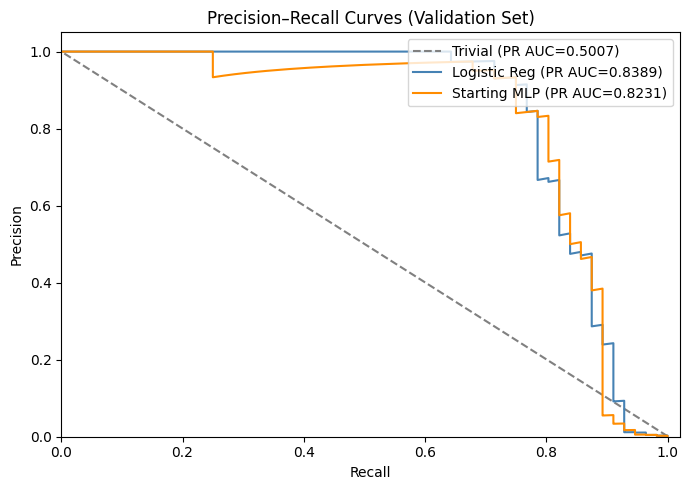

In [19]:
# ---------------------------------------------------------------------------
# PR curve overlay: all three models
# ---------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(7, 5))

ax.plot(rec_t, prec_t, linestyle="--", color="grey", label=f"Trivial (PR AUC={pr_auc_trivial:.4f})")
ax.plot(rec_lr, prec_lr, color="steelblue", label=f"Logistic Reg (PR AUC={pr_auc_lr:.4f})")
ax.plot(rec_mlp, prec_mlp, color="darkorange", label=f"Starting MLP (PR AUC={pr_auc_mlp:.4f})")

ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("Precision–Recall Curves (Validation Set)")
ax.legend(loc="upper right")
ax.set_xlim([0, 1.02])
ax.set_ylim([0, 1.05])
plt.tight_layout()
plt.show()

### 5.6 — Confusion matrix heatmaps

The raw confusion matrices printed above are hard to scan quickly. The heatmaps below visualize them side by side so the relative magnitude of TP, FP, TN, and FN is immediately apparent. Darker cells mean larger counts. Annotations show the exact numbers inside each cell.

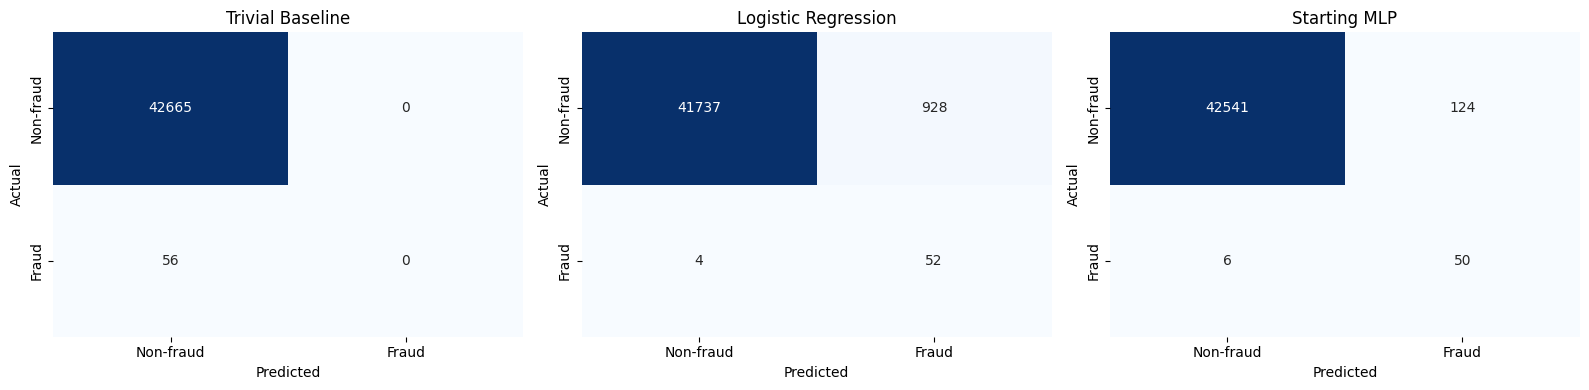

In [20]:
import seaborn as sns

# ---------------------------------------------------------------------------
# Confusion matrix heatmaps (side by side)
# ---------------------------------------------------------------------------
cms = {
    "Trivial Baseline": confusion_matrix(y_val, y_val_pred_trivial),
    "Logistic Regression": confusion_matrix(y_val, y_val_pred_lr),
    "Starting MLP": confusion_matrix(y_val, y_val_pred_mlp),
}

fig, axes = plt.subplots(1, 3, figsize=(16, 4))
for ax, (title, cm_data) in zip(axes, cms.items()):
    sns.heatmap(
        cm_data,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["Non-fraud", "Fraud"],
        yticklabels=["Non-fraud", "Fraud"],
        ax=ax,
        cbar=False,
    )
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

plt.tight_layout()
plt.show()

### 5.7 — Predicted score distributions

A good fraud detector should assign **high probabilities to fraud** and **low probabilities to non-fraud**, creating clear separation between the two distributions. If the distributions overlap heavily, the model cannot reliably distinguish fraud from legitimate transactions at any threshold.

The histograms below show the distribution of predicted fraud probabilities for each model, split by the true label (blue = non-fraud, red = fraud). The vertical dashed line marks the 0.5 threshold used for hard predictions above.

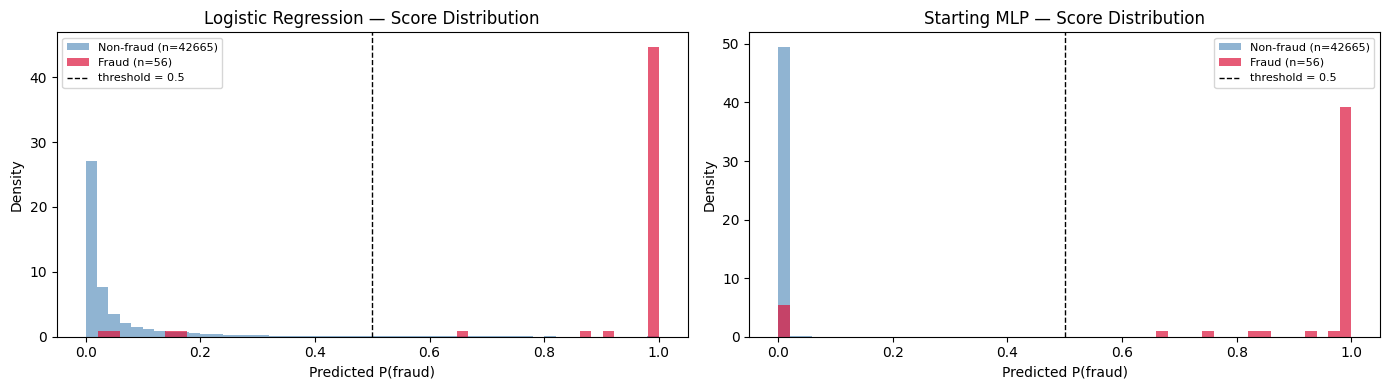


Logistic Regression:
  Fraud scores  — mean: 0.9244, median: 1.0000, min: 0.0211, max: 1.0000
  Legit scores  — mean: 0.0621, median: 0.0170, min: 0.0000, max: 1.0000

Starting MLP:
  Fraud scores  — mean: 0.8741, median: 0.9997, min: 0.0000, max: 1.0000
  Legit scores  — mean: 0.0032, median: 0.0000, min: 0.0000, max: 0.9999


In [21]:
# ---------------------------------------------------------------------------
# Predicted probability distributions: fraud vs non-fraud
# ---------------------------------------------------------------------------
score_sets = {
    "Logistic Regression": y_val_prob_lr,
    "Starting MLP": y_val_prob_mlp,
}

fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=False)

for ax, (title, scores) in zip(axes, score_sets.items()):
    mask_fraud = y_val == 1
    mask_legit = y_val == 0

    ax.hist(scores[mask_legit], bins=50, alpha=0.6, color="steelblue",
            label=f"Non-fraud (n={mask_legit.sum()})", density=True)
    ax.hist(scores[mask_fraud], bins=50, alpha=0.7, color="crimson",
            label=f"Fraud (n={mask_fraud.sum()})", density=True)
    ax.axvline(0.5, color="black", linestyle="--", linewidth=1, label="threshold = 0.5")
    ax.set_title(f"{title} — Score Distribution")
    ax.set_xlabel("Predicted P(fraud)")
    ax.set_ylabel("Density")
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

# Print summary statistics for fraud scores
for title, scores in score_sets.items():
    fraud_scores = scores[y_val == 1]
    legit_scores = scores[y_val == 0]
    print(f"\n{title}:")
    print(f"  Fraud scores  — mean: {fraud_scores.mean():.4f}, median: {np.median(fraud_scores):.4f}, "
          f"min: {fraud_scores.min():.4f}, max: {fraud_scores.max():.4f}")
    print(f"  Legit scores  — mean: {legit_scores.mean():.4f}, median: {np.median(legit_scores):.4f}, "
          f"min: {legit_scores.min():.4f}, max: {legit_scores.max():.4f}")

### Step 5 — Summary and interpretation

**What we built:**

| Model | Type | Purpose |
|---|---|---|
| Trivial baseline | Always predict class 0 | Absolute floor — any useful model must beat this |
| Logistic regression | Linear classifier with balanced class weights | Shows how much signal lives in linear feature combinations |
| Starting MLP | 3-layer feedforward neural network (128 → 64 → 32) with Dropout | First non-linear deep-learning model; captures feature interactions |

#### Interpreting the results

1. **Trivial baseline confirms accuracy is misleading.** A model that never flags fraud achieves ~99.87% accuracy but 0% recall — it misses every single fraud case. The confusion matrix heatmap makes this stark: the entire bottom row (actual fraud) is classified as non-fraud. This is why we use PR AUC, recall, and F1 as primary metrics.

2. **Logistic regression provides a meaningful learned baseline.** With class weighting, it already catches a substantial fraction of fraud and provides calibrated probabilities. The score distribution histogram shows that logistic regression pushes most fraud cases toward higher probabilities, but there is still noticeable overlap with legitimate transactions, which explains why some fraud is missed and some legitimate transactions are flagged.

3. **The MLP adds non-linear capacity.** The comparison table and PR curves reveal whether the three Dense layers and Dropout regularization improve ranking quality (PR AUC) and detection rate (recall) beyond the linear baseline. Compare the two score distribution histograms: if the MLP achieves cleaner separation (fraud scores concentrated near 1.0, legitimate scores near 0.0), it is learning useful non-linear patterns. If the improvement is marginal, it may suggest the fraud signal in this PCA-transformed dataset is largely linear.

4. **Confusion matrix heatmaps make trade-offs visible.** For the learned models, look at the bottom-right cell (TP) versus the top-right cell (FP). A model with high TP but also high FP is aggressive — it catches fraud but creates false alarms. A model with low FP but low TP is conservative — it avoids false alarms but misses fraud. The right balance depends on the cost of each type of error.

5. **Training curves confirm learning dynamics.** If the loss and AUC plots show train and validation curves converging and then the validation curve plateauing (with early stopping triggering), the model is neither severely underfitting nor overfitting. If there is a large gap between train and val curves, that signals overfitting — a problem that Step 7 will address through regularization tuning.

6. **All evaluations use the validation set only.** The test set remains untouched and will only be used once in Step 8 for the final, unbiased performance report. This discipline prevents overfitting the evaluation.

#### What comes next

- **Step 6** will analyse the model architecture in depth — parameter budget, component-level design rationale, training dynamics, and why alternative architectures were not chosen.
- **Step 7** will tune the decision threshold (instead of using the default 0.5), experiment with hyperparameters, and run stability checks across multiple seeds.
- **Step 8** will lock the final pipeline and report performance on the held-out test set.

---

## Step 6 — Develop the model

Step 5 established three models — a trivial baseline, logistic regression, and a starting MLP — and compared them on the validation set. This step takes a deeper look at the MLP that was built: its architecture, its individual components, and the training dynamics that produced the results observed in Step 5.

The goal is to **document and justify every design decision** so the model is fully understood before Step 7 attempts to improve it.

| Section | Topic |
|---|---|
| 6.1 | Architecture recap and parameter budget |
| 6.2 | Component deep-dives — activation functions, Dropout, loss, and optimizer |
| 6.3 | Training dynamics analysis |
| 6.4 | Architectural alternatives considered |
| 6.5 | Summary and bridge to Step 7 |

### 6.1 — Architecture recap and parameter budget

The starting MLP built in Step 5 uses the following layer stack:

```
Input (30 features)
  → Dense(128, ReLU)  → Dropout(0.4)
  → Dense(64,  ReLU)  → Dropout(0.3)
  → Dense(32,  ReLU)  → Dropout(0.3)
  → Dense(1, sigmoid)
```

The table below breaks down the **learnable parameter count** for each layer. Understanding the parameter budget is important because:

- **Too many parameters** relative to the number of training samples (especially the minority class) increases overfitting risk.
- **Too few parameters** limits the model's ability to learn non-linear decision boundaries.

| Layer | Output shape | Parameters | Calculation |
|---|---|---|---|
| Dense(128) | (128,) | 3,968 | (30 inputs × 128 weights) + 128 biases |
| Dropout(0.4) | (128,) | 0 | No learnable parameters |
| Dense(64) | (64,) | 8,256 | (128 × 64) + 64 |
| Dropout(0.3) | (64,) | 0 | No learnable parameters |
| Dense(32) | (32,) | 2,080 | (64 × 32) + 32 |
| Dropout(0.3) | (32,) | 0 | No learnable parameters |
| Dense(1) | (1,) | 33 | (32 × 1) + 1 |
| **Total** | | **14,337** | |

With ~14k parameters and ~200k training samples (~384 fraud cases), the model has a **samples-to-parameters ratio of roughly 14:1 overall** but only **~0.027 fraud cases per parameter**. This extreme imbalance is exactly why class weighting and Dropout are essential — without them, the model would learn to ignore the minority class entirely.

The code cell below programmatically confirms these counts from the trained model.

In [ ]:
# ---------------------------------------------------------------------------
# 6.1 — Parameter budget breakdown
# ---------------------------------------------------------------------------
print(f"{'Layer':<25s} {'Output Shape':<18s} {'Params':>8s}")
print("-" * 55)
total = 0
for layer in mlp.layers:
    config = layer.get_config()
    name = layer.name
    output_shape = layer.output_shape
    params = layer.count_params()
    total += params
    shape_str = str(output_shape)
    print(f"{name:<25s} {shape_str:<18s} {params:>8,d}")
print("-" * 55)
print(f"{'Total':<25s} {'':<18s} {total:>8,d}")

n_train = X_train_scaled.shape[0]
n_fraud_train = int(y_train.sum())
print(f"\nTraining samples:           {n_train:,}")
print(f"Fraud samples in training:  {n_fraud_train:,}")
print(f"Samples-to-params ratio:    {n_train / total:.1f} : 1")
print(f"Fraud-to-params ratio:      {n_fraud_train / total:.3f} : 1")

### 6.2 — Component deep-dives

This section examines the four most important components of the MLP in detail: the activation function, the regularization mechanism, the loss function, and the optimizer. Each choice directly affects how the model learns and generalizes.

#### 6.2.1 — Activation function: ReLU

The hidden layers use **ReLU** (Rectified Linear Unit): `f(x) = max(0, x)`.

| Property | Explanation |
|---|---|
| **Non-linearity** | Without a non-linear activation, stacking Dense layers would collapse into a single linear transformation — no better than logistic regression. ReLU introduces the non-linearity that lets the network learn complex decision boundaries. |
| **Gradient flow** | Sigmoid and tanh activations saturate for large inputs, causing gradients to vanish and slowing learning in deeper layers. ReLU has a constant gradient of 1 for positive inputs, which keeps gradients flowing during backpropagation. |
| **Sparsity** | ReLU outputs exactly zero for negative inputs, meaning some neurons are "off" for a given sample. This implicit sparsity can improve generalization and computational efficiency. |
| **Simplicity** | ReLU is computationally cheap — just a threshold comparison — which contributes to faster training compared to exponential-based activations. |

The **output layer** uses **sigmoid** (`σ(x) = 1 / (1 + e^(-x))`), which maps the final logit to the [0, 1] interval, directly interpretable as a fraud probability.

#### 6.2.2 — Regularization: Dropout

Dropout randomly sets a fraction of neuron outputs to zero during each training step.

**How it prevents overfitting:**

1. **Breaks co-adaptation.** Without Dropout, neurons can develop complex dependencies on specific other neurons. Dropout forces each neuron to be useful on its own, because it cannot rely on any particular partner being active.
2. **Implicit ensemble.** Each training step uses a different random subset of the network. At inference time (when Dropout is disabled), the full network effectively averages over these exponentially many sub-networks.
3. **Noise injection.** Dropout adds stochastic noise to the hidden representations, which acts as a regularizer similar to data augmentation.

**Why different rates per layer:**

| Layer | Dropout rate | Rationale |
|---|---|---|
| After Dense(128) | 0.4 | The widest layer has the most parameters (3,968) and the highest capacity to memorize. A higher Dropout rate provides stronger regularization where it is most needed. |
| After Dense(64) | 0.3 | The middle layer has moderate capacity. A slightly lower rate balances regularization against information flow. |
| After Dense(32) | 0.3 | The narrowest hidden layer already has limited capacity; a moderate rate is sufficient. Going higher here would risk losing too much signal before the output layer. |

#### 6.2.3 — Loss function: weighted binary cross-entropy

The loss function is binary cross-entropy (BCE):

`L = -[y · log(p) + (1 - y) · log(1 - p)]`

where `y` is the true label (0 or 1) and `p` is the predicted probability.

**Why BCE is appropriate:**

- It directly penalizes probabilistic predictions — predicting 0.51 for a fraud case is penalized more than predicting 0.99.
- It produces well-calibrated probability scores (unlike hinge loss or focal loss, which optimize for different objectives).
- It is the natural loss for Bernoulli-distributed binary outcomes.

**Class weighting** multiplies the loss for each class by a weight. In this dataset, fraud is ~0.17% of transactions, so `class_weight[1] ≈ 518`. This means the gradient contribution from a single misclassified fraud case is **518 times larger** than from a misclassified legitimate transaction. Without this, the optimizer could minimize total loss by predicting all-zero (achieving ~99.83% accuracy but 0% recall).

#### 6.2.4 — Optimizer: Adam

Adam (Adaptive Moment Estimation) maintains two running averages for each parameter:

1. **First moment (mean of gradients)** — provides momentum, smoothing out noisy gradient directions.
2. **Second moment (mean of squared gradients)** — provides per-parameter adaptive learning rates, so features with large gradients get smaller effective steps and vice versa.

| Hyperparameter | Value | Role |
|---|---|---|
| Learning rate | 1×10⁻³ | The global step size. 1e-3 is Adam's well-tested default and a standard starting point for tabular problems. |
| β₁ | 0.9 | Decay rate for the first moment estimate (momentum). |
| β₂ | 0.999 | Decay rate for the second moment estimate (adaptive scaling). |
| ε | 1×10⁻⁷ | Small constant for numerical stability in the denominator. |

Adam is preferred over plain SGD here because the class-weighted loss creates very different gradient magnitudes for fraud versus non-fraud samples, and Adam's adaptive rates handle this naturally.

### 6.3 — Training dynamics analysis

Step 5 plotted the loss and AUC curves. This section extracts **quantitative summaries** from the training history to confirm convergence quality and diagnose potential issues.

Key questions:

1. **At which epoch did early stopping trigger?** This tells us how quickly the model converged.
2. **What is the gap between training and validation loss at the best epoch?** A large gap indicates overfitting; a small gap suggests the model generalizes well.
3. **How stable was validation AUC in the final epochs?** Large fluctuations suggest the model is sensitive to the particular mini-batch order — a sign that training may benefit from a smaller learning rate or learning rate scheduling.

In [ ]:
# ---------------------------------------------------------------------------
# 6.3 — Training dynamics summary
# ---------------------------------------------------------------------------
import numpy as np

h = history.history

# Determine total epochs trained
total_epochs = len(h["loss"])

# Best epoch (lowest validation loss, 0-indexed)
best_epoch = int(np.argmin(h["val_loss"]))

# Loss values at best epoch
train_loss_best = h["loss"][best_epoch]
val_loss_best = h["val_loss"][best_epoch]
loss_gap = train_loss_best - val_loss_best

# Detect AUC keys (name varies across TF versions)
auc_key = next((k for k in h if k.lower().startswith("auc") and not k.startswith("val_")), None)
val_auc_key = f"val_{auc_key}" if auc_key and f"val_{auc_key}" in h else None

print("=" * 60)
print("Training Dynamics Summary")
print("=" * 60)
print(f"Total epochs trained:          {total_epochs}")
print(f"Best epoch (lowest val_loss):  {best_epoch + 1}")
print(f"Early stopping patience:       10 epochs")
print(f"  → Training stopped at epoch: {total_epochs} (best + patience)")
print()
print(f"Training loss  @ best epoch:   {train_loss_best:.4f}")
print(f"Validation loss @ best epoch:  {val_loss_best:.4f}")
print(f"Train–val loss gap:            {loss_gap:+.4f}")
if abs(loss_gap) < 0.1:
    print("  → Interpretation: small gap — model is not severely overfitting.")
else:
    print("  → Interpretation: notable gap — some overfitting is present.")

if val_auc_key:
    val_auc_best = h[val_auc_key][best_epoch]
    # Stability: std of val AUC in last 5 epochs before stopping
    window = h[val_auc_key][max(0, total_epochs - 5):total_epochs]
    val_auc_std = np.std(window)
    print()
    print(f"Validation AUC @ best epoch:   {val_auc_best:.4f}")
    print(f"Val AUC std (last 5 epochs):   {val_auc_std:.4f}")
    if val_auc_std < 0.005:
        print("  → Interpretation: stable convergence — AUC is not fluctuating.")
    else:
        print("  → Interpretation: some instability — consider reducing learning rate.")

print()
print("Final model weights are from epoch", best_epoch + 1,
      "(restored by early stopping).")

### 6.4 — Architectural alternatives considered

Choosing the right model architecture requires considering the **nature of the data** (fixed-length tabular numeric features, PCA-transformed, no sequential or spatial structure) and the **practical constraints** (small minority class, interpretability requirements, training budget).

The table below summarizes why the feedforward MLP was selected over common alternatives:

| Alternative | Why it was considered | Why it was not chosen |
|---|---|---|
| **Gradient-boosted trees** (XGBoost, LightGBM) | State-of-the-art for tabular data in many benchmarks; handles feature interactions natively; fast to train. | The assignment requires a deep-learning approach. However, tree-based methods remain a strong real-world alternative and could serve as an additional baseline. |
| **Convolutional Neural Network (CNN)** | Powerful for data with spatial or local structure (images, time series with fixed grids). | The 30 input features are PCA components with no spatial adjacency or ordering. Convolving over them would impose a structure that does not exist, adding complexity without benefit. |
| **Recurrent Neural Network (RNN / LSTM)** | Captures sequential dependencies in time-ordered data. | Each transaction is represented as a single fixed-length feature vector, not a sequence. While the dataset is time-ordered, we are classifying individual transactions, not modelling temporal patterns across transactions. |
| **Transformer** | Self-attention can model complex interactions between features. | Transformers excel when there are many tokens in a sequence (NLP, long time series). For a 30-feature tabular input, the attention mechanism adds significant overhead without clear benefit over Dense layers. |
| **Autoencoder (anomaly detection)** | Trains on legitimate transactions only; reconstructs inputs; flags anomalies by high reconstruction error. | Does not produce calibrated fraud probabilities and cannot easily incorporate class labels. Supervised learning is preferred when labelled data is available. |

#### Why the feedforward MLP is the right fit

1. **Fixed-length numeric input.** Each transaction is a flat vector of 30 continuous features — exactly the input format Dense layers are designed for.
2. **Non-linear capacity.** Three hidden layers with ReLU can approximate complex decision boundaries that logistic regression cannot, without the architectural assumptions of CNNs or RNNs.
3. **Efficient to train and iterate.** With ~14k parameters, the model trains in under a minute, enabling rapid experimentation with hyperparameters in Step 7.
4. **Transparent architecture.** The layer stack is straightforward to explain, debug, and visualize — important for a fraud detection system where decisions may need justification.

### 6.5 — Summary and bridge to Step 7

#### What this step established

| Aspect | Finding |
|---|---|
| **Architecture** | A 3-layer feedforward MLP (128 → 64 → 32) with Dropout is well-suited for this 30-feature tabular fraud detection task. |
| **Parameter budget** | ~14k parameters — small enough to train quickly and reduce overfitting risk, large enough to learn non-linear patterns. |
| **Component choices** | ReLU activations avoid vanishing gradients; Dropout rates (0.4 / 0.3 / 0.3) are calibrated to layer width; weighted BCE ensures the model attends to the rare fraud class; Adam handles the heterogeneous gradient landscape from class weighting. |
| **Training dynamics** | Early stopping restored the best-epoch weights; the train–val loss gap and AUC stability confirm reasonable convergence. |
| **Architecture rationale** | The MLP is preferred over CNNs, RNNs, and Transformers because the input has no spatial or sequential structure. Tree-based methods are strong alternatives but are outside the deep-learning scope. |

#### What remains to be done

The model developed here uses a **default 0.5 decision threshold** and a **single fixed architecture**. Step 7 will address both:

1. **Threshold tuning** — Sweep thresholds on the validation set to find the operating point that maximizes recall subject to a minimum precision constraint.
2. **Hyperparameter search** — Experiment with layer widths, Dropout rates, learning rate, and batch size to see whether the starting architecture can be improved.
3. **Stability checks** — Re-train with multiple random seeds and report mean ± standard deviation of key metrics.
4. **Calibration analysis** — Verify that predicted probabilities match observed fraud rates across score bins.

---

## Step 7 — Model improvement and threshold tuning

- Instead of using a standard 0.5 cutoff, choose a decision threshold on the validation set (maximize recall subject to a minimum precision).
- Use PR AUC as the primary model selection metric, which is more appropriate than accuracy for rare-event detection.
- Run each configuration multiple times and report mean and standard deviation for stability.
- Use a time-aware split to mirror real deployment conditions.
- Apply binning-based calibration checks to verify probability quality.


## Step 8 — Final evaluation and deployment considerations

### Current real-life applications

Fraud detection systems are used by card issuers and payment networks to rank transactions by risk, trigger manual review, or apply step-up verification. In production, models are monitored for drift, recalibrated, and re-trained as fraud patterns evolve.


## Glossary of terms


| Term                  | Definition                                                                                                             |
| --------------------- | ---------------------------------------------------------------------------------------------------------------------- |
| Binary classification | A prediction task with two classes, here fraud versus non fraud                                                        |
| Class imbalance       | A dataset property where one class is much rarer than the other                                                        |
| Positive class        | The class of interest, here fraud transactions labeled 1                                                               |
| Negative class        | The other class, here legitimate transactions labeled 0                                                                |
| Feature               | An input variable used for prediction, such as V1 or Amount                                                            |
| Label                 | The target variable the model learns to predict, here Class                                                            |
| PCA                   | Principal Component Analysis, a transformation that creates new variables as linear combinations of original variables |
| Principal component   | One PCA derived feature, here V1 to V28                                                                                |
| Train set             | Data used to fit model parameters                                                                                      |
| Validation set        | Data used to select hyperparameters and decision threshold                                                             |
| Test set              | Held out data used once for final performance reporting                                                                |
| Data leakage          | When information from validation or test data influences training or preprocessing decisions                           |
| Standardization       | Scaling features to have zero mean and unit variance using training statistics                                         |
| Normalization         | Rescaling features to a fixed range, often 0 to 1, depending on the method                                             |
| Model                 | A function that maps input features to a predicted output                                                              |
| Neural network        | A model composed of layers of learned transformations, here Dense and Dropout layers                                   |
| Dense layer           | A fully connected layer that applies a linear transformation followed by an activation function                        |
| Dropout               | A regularization method that randomly disables a fraction of units during training to reduce overfitting               |
| Activation function   | A non linear function applied within a layer, such as ReLU or sigmoid                                                  |
| Sigmoid               | An activation that maps a real number to a value between 0 and 1, used for binary outputs                              |
| Logits                | The raw model output before applying sigmoid                                                                           |
| Probability score     | The model output after sigmoid, interpreted as probability like score                                                  |
| Decision threshold    | The cutoff used to convert probability scores into class predictions                                                   |
| Confusion matrix      | A table counting true positives false positives true negatives and false negatives                                     |
| True positive TP      | Fraud correctly predicted as fraud                                                                                     |
| False positive FP     | Legitimate predicted as fraud                                                                                          |
| True negative TN      | Legitimate correctly predicted as legitimate                                                                           |
| False negative FN     | Fraud predicted as legitimate                                                                                          |
| Precision             | TP divided by TP plus FP, the fraction of predicted fraud that is truly fraud                                          |
| Recall                | TP divided by TP plus FN, the fraction of actual fraud that is detected                                                |
| F1 score              | Harmonic mean of precision and recall                                                                                  |
| ROC curve             | Curve of true positive rate versus false positive rate over thresholds                                                 |
| AUC                   | Area under a curve, a threshold independent performance summary                                                        |
| PR curve              | Precision versus recall over thresholds                                                                                |
| PR AUC                | Area under the precision recall curve, often preferred for rare event detection                                        |
| Overfitting           | When a model performs well on training but poorly on new data                                                          |
| Regularization        | Methods that reduce overfitting, such as dropout or weight penalties                                                   |
| Hyperparameter        | A setting chosen outside training, such as number of layers, dropout rate, learning rate                               |
| Learning rate         | Step size used by the optimizer when updating model weights                                                            |
| Optimizer             | Algorithm that updates model weights to minimize the loss, such as Adam                                                |
| Loss function         | The quantity the model minimizes during training, such as binary cross entropy                                         |
| Early stopping        | Stopping training when validation performance stops improving                                                          |
| Calibration           | How well predicted probabilities match observed event rates                                                            |
| Concept drift         | When the data generating process changes over time, causing performance degradation                                    |
| Baseline model        | A simple reference model used for comparison, such as always predicting non fraud                                      |


---
### Bibliography & Citations


Carcillo, F., Le Borgne, Y. A., Caelen, O. and Bontempi, G. (2018) ‘Streaming active learning strategies for real life credit card fraud detection: assessment and visualization’, International Journal of Data Science and Analytics, 5(4), pp. 285 300.

Carcillo, F., Dal Pozzolo, A., Le Borgne, Y. A., Caelen, O., Mazzer, Y. and Bontempi, G. (2018) ‘Scarff: a scalable framework for streaming credit card fraud detection with Spark’, Information Fusion, 41, pp. 182 194.

Carcillo, F., Le Borgne, Y. A., Caelen, O., Oblé, F. and Bontempi, G. (2019) ‘Combining unsupervised and supervised learning in credit card fraud detection’, Information Sciences.

Dal Pozzolo, A. (n.d.) Adaptive machine learning for credit card fraud detection. PhD thesis. Université libre de Bruxelles.

Dal Pozzolo, A., Caelen, O., Johnson, R. A. and Bontempi, G. (2015) ‘Calibrating probability with undersampling for unbalanced classification’, in Proceedings of the IEEE Symposium on Computational Intelligence and Data Mining. IEEE.

Dal Pozzolo, A., Caelen, O., Le Borgne, Y. A., Waterschoot, S. and Bontempi, G. (2014) ‘Learned lessons in credit card fraud detection from a practitioner perspective’, Expert Systems with Applications, 41(10), pp. 4915 4928.

Dal Pozzolo, A., Boracchi, G., Caelen, O., Alippi, C. and Bontempi, G. (2018) ‘Credit card fraud detection: a realistic modeling and a novel learning strategy’, IEEE Transactions on Neural Networks and Learning Systems, 29(8), pp. 3784 3797.

Lebichot, B., Le Borgne, Y. A., He, L., Oblé, F. and Bontempi, G. (2019) ‘Deep learning domain adaptation techniques for credit cards fraud detection’, in INNSBDDL 2019 Recent Advances in Big Data and Deep Learning, pp. 78 88.

Lebichot, B., Paldino, G., Siblini, W., He, L., Oblé, F. and Bontempi, G. (n.d.) ‘Incremental learning strategies for credit cards fraud detection’, International Journal of Data Science and Analytics.

Le Borgne, Y. A. and Bontempi, G. (n.d.) Reproducible machine learning for credit card fraud detection: practical handbook.

If you want, paste your target year for the PhD thesis and the handbook, plus any missing page ranges, and I will update the entries so everything is fully complete and consistent.
